# Constructing a Credit Card Fraud Detection Model

## What this notebook includes
* Background on credit card fraud.
* Summary of the dataset being used.
* Deciding on the performance measures for our problem.
* Analytical and visual exploration of the dataset.
* Discussion of the imbalance in the dataset and the approaches to overcome the challenges that come with it.
* Dimensionality reduction to visualise the clusters of both non-fraud and fraud transactions.
* Construction and comparison of various models to detect fraud credit card transactions.
* Challenges and acknowledgement of assumptions that were faced with the project.
* Suggestions for improvement.

### Background on problem
Credit card fraud involves utilising another individual's personal information to commit fraud and make transactions/purchase goods from their account. The fraudelent transactions can either be *card-present* (i.e. with the physical presence of the card, using the chip and pin system etc.) or *card-not-present* (i.e. online transactions).

It would be useful to have a system that could detect a fraud transaction or maybe even gives a score for each transaction on how likely it is to be fraud.

The work presented in this notebook will try to model such a system, trained using a dataset that represents real-world transactions (of which, some are labelled as 'fraud'). We will try and create a classifier because we will be trying to classify fraud transactions.

### The dataset
The dataset used represents real-world transactions over a 2-day period, some of which are labelled as 'fraud' whilst most are labelled as 'non-fraud' (i.e. genuine).

The features of the dataset are not explicitly described. They are the results of PCA transformation done to the original dataset to protect the privacy of the individuals from which the transaction data has come from.

Nevertheless, the dataset has been used in many applications when constructing credit card fraud detection models so it has been proven to be sufficient for the use-case.

We will later see that the dataset suffers from a common problem called '**class imbalance**'. This is one the data is skewed towards one class (in this case, more than 99% of the data belongs to the majority class!). We will also be utilising methods to try to overcome this problem.

### Performance Metrics
Before we begin, we will discuss the performance measure(s) that we will use to compare our models and choose the best one. For classification problems, we usually use some a combination of - accuracy, confusion matrix, precision & recall, F1 score, specificity, and ROC Curve, depending on our end goal.

In our case, *accuracy* won't be the most important metric to look at. This is because accuracy is just the amount of correct predicitions made by the model divided by all predictions made by the model. We can see exactly why this would be a problem if you just predict all transactions to be non-fraud - then we will get an accuracy equal to the percentage of how many non-fraud transactions are in the dataset. Therefore, if the percentage of non-fraud transactions in the dataset is more then 99%, we will get an accuracy of 99%. If the model overfits (which usually happens with imbalanced data), this will be the result and it would be difficult to assess how well the model performs just from this metric.

The main metric we will focus on is **recall**. Recall is the *ratio of positives the model predicted right out of all those positives that exist*. If we think of 'fraud' transactions as our positive case (because we want to be able to detect fraud transactions), then this would be the amount of fraud transactions we correctly identified out of all fraud transactions that exist. If this was to be 100%, then the model would be really good at detecting fraud transactions.

Of course, we will also aim to perform well on other metrics too to ensure our model is rightly balanced. This is important because if we just classified all transactions as 'fraud', we'd get 100% recall but poor everything else.

*Specificity* is the opposite of recall. In our case, this would mean the ratio of non-fraud transactions correctly classified out of all non-fraud transactions that exist. The reason why this will be important in our case is because, while we want recall to be high, if the model's specificity is low then it would mean that the model is missclassifying a lot of non-fraud cases. Sure, if I detected all of your transactions as fraud and asked you if you made them, I would be able to flag all the ones that are actually fraud. However, since this is the minority case then it wouldn't be ideal for you to be flagged about every single transaction because most of them will be non-fraud, it would be tiresome. So along with a high recall, we care about a high specificity.

*Precision* is the ratio of positives predicted right out of all predictions that were made as positive, i.e. if the model predicted 10 fraud transactions and got only 8 of them correct, the precision is 80%. We can sacrifice some precision for extra recall because it is more important to us. In the example, it would not be bad if we missclassified those 2 non-fraud cases as fraud in a real-world sense (to be extra careful) as long as only 8 fraud transactions existed, meaning we managed to detect all of them (and get a recall of 100%!)

If the above example is confusing to understand, imagine there are 8 fraud transactions, and many non-fraud transactions. Our model identifies the 8 fraud transactions as fraud, but also missclassifies 2 non-fraud transactions as fraud. The precision would be 80% (8 correctly classified as fraud out of 10 classified as fraud), but the recall would be 100% (8 correctly classified as fraud out of 8 fraud cases). There are many cases in which precision may be more important, but not here.

*F1* score is a calculation that takes into account both precision and recall. As we mentioned, we want our model to be performing well on recall, but also balance on other metrics, so we will take the F1 score into consideration. Another metric that takes into account recall is the area under the ROC curve.

# Import the data and libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import time

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Pre-processing
from sklearn.preprocessing import RobustScaler

# Imbalance
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks, NearMiss
from imblearn.pipeline import Pipeline

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Ensemble Learning
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


# Validation & Testing
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, confusion_matrix

# Create dataframe using the data from a csv file
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Exploratory Data Analysis

## Creating a Test Set
Before we continue with anything, we will create a test set and make sure the classes are proportionate in the test set with the train.

In [2]:
# number of transactions
rows = df.shape[0]

# number of non-fraud and fraud transactions
nf_rows = df['Class'].value_counts()[0]
f_rows = df['Class'].value_counts()[1]

print("Original dataset:")
print("Transactions -", rows)
print("Non-fraud transactions -", nf_rows, "-", round(nf_rows/rows*100, 2), "%")
print("Fraud transactions -", f_rows, "-", round(f_rows/rows*100, 2), "%")

Original dataset:
Transactions - 284807
Non-fraud transactions - 284315 - 99.83 %
Fraud transactions - 492 - 0.17 %


We want to keep the same proportions as the original dataset.

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# creating new df to train with
df_train = pd.concat([X_train, y_train], axis=1)
df_train = df_train.sort_values(by='Time').reset_index(drop=True)

# test df
df_test = pd.concat([X_test, y_test], axis=1)
df_test = df_test.sort_values(by='Time').reset_index(drop=True)

In [4]:
# amounts and %s of transactions (total, non-fraud and fraud) in train df
rows_train = df_train.shape[0]
nf_rows_train = df_train['Class'].value_counts()[0]
f_rows_train = df_train['Class'].value_counts()[1]
print("Training dataset:")
print("Transactions -", rows_train)
print("Non-fraud transactions -", nf_rows_train, "-", round(nf_rows_train/rows_train*100, 2), "%")
print("Fraud transactions -", f_rows_train, "-", round(f_rows_train/rows_train*100, 2), "%")

print("\n")

# amounts and %s of transactions (total, non-fraud and fraud) in test df
rows_test = df_test.shape[0]
nf_rows_test = df_test['Class'].value_counts()[0]
f_rows_test = df_test['Class'].value_counts()[1]
print("Test dataset:")
print("Transactions -", rows_test)
print("Non-fraud transactions -", nf_rows_test, "-", round(nf_rows_test/rows_test*100, 2), "%")
print("Fraud transactions -", f_rows_test, "-", round(f_rows_test/rows_test*100, 2), "%")

Training dataset:
Transactions - 227845
Non-fraud transactions - 227451 - 99.83 %
Fraud transactions - 394 - 0.17 %


Test dataset:
Transactions - 56962
Non-fraud transactions - 56864 - 99.83 %
Fraud transactions - 98 - 0.17 %


## Shape

In [5]:
columns_train = len(list(df_train.columns.values))

print("The dataframe has", rows_train, "rows of transactions, and", columns_train,  "columns.")

The dataframe has 227845 rows of transactions, and 31 columns.


The first thing to note is that there are 227845 rows of transaction data, and 31 columns (assumed to be 30 feature variables and 1 target).

## Preview

In [6]:
df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

Upon first viewing, it's revealed that there are 28 PC features (V1 - V28) created by the previously done PCA transformation. The other features are 'Time' and 'Amount'. 'Class' is the target label column.

*Time* - Number of seconds between the current transaction and the first transaction in the dataset.

*Amount* - Transaction amount.

*Class* - 1 if fraud, otherwise 0.

## Statistical Analysis

In [8]:
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94885.093704,0.000795,-0.000481,-0.000383,-0.000020,0.000175,-0.001171,0.000077,-0.000434,0.000702,...,0.000370,0.000303,0.000050,-0.000277,-0.000655,0.000126,-0.000070,0.000154,88.176298,0.001729
std,47488.415034,1.958926,1.649092,1.515292,1.415867,1.379569,1.331218,1.238431,1.191482,1.097351,...,0.734963,0.725735,0.627419,0.605322,0.521236,0.481939,0.404934,0.326939,250.722602,0.041548
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54228.000000,-0.919893,-0.598761,-0.891767,-0.847111,-0.692100,-0.768603,-0.553481,-0.207839,-0.640307,...,-0.228250,-0.542056,-0.161932,-0.354843,-0.316907,-0.326491,-0.070740,-0.052931,5.640000,0.000000
50%,84805.000000,0.018692,0.064746,0.179859,-0.021361,-0.054757,-0.274156,0.040420,0.023219,-0.050653,...,-0.029280,0.006599,-0.010983,0.040778,0.016081,-0.051623,0.001463,0.011221,22.000000,0.000000
75%,139364.000000,1.315616,0.803876,1.026457,0.742281,0.611259,0.397501,0.570530,0.327824,0.598254,...,0.186365,0.528282,0.147589,0.438966,0.349880,0.240835,0.091180,0.078118,77.490000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000,1.000000


In [9]:
df_train.isnull().values.any()
# no nulls

False

In [10]:
print("Out of", rows_train, "transactions:")
print("There are ", nf_rows_train, "non fraud transactions in the dataset, which makes up around", round(nf_rows_train/rows_train*100, 2), "% of it.")
print("The remaining ", f_rows_train, "are fraud transactions, these make up about", round(f_rows_train/rows_train*100, 2), "% of it.")

Out of 227845 transactions:
There are  227451 non fraud transactions in the dataset, which makes up around 99.83 % of it.
The remaining  394 are fraud transactions, these make up about 0.17 % of it.


### Null Values
We can see that there are no null values in the dataset.

### Time
Each time entry is the amount of seconds passed from the first transaction of the dataset. As stated before, the transaction data spans over 2 days. The max value for the time column is 12 seconds off of the 48 hour mark from the first transaction.

### Principal Components (V1-V28)
Since we know little of what the principal component features describe, we will save their analysis for visual-analytics.

### Amount
The mean transaction amount is approximately 88 (currency unknown - possibly euros or pounds). The standard deviation is high, at about 248 (coefficient of variation = ~2.82). The SD of the transaction amount has been affected by large outliers. This is evident as the max transaction amount is 25,691.16, whereas the upper quartile is 77.37.

### Class
The data is, as stated before, highly imbalanced with only **0.17%** (394 rows) of the transactions as *fraud*, while the remaining **99.83%** (227451 rows) are *non-fraud*.

#### Class Imbalance

The imbalance in the dataset presents a problem to our goal. When we create our model using the dataset, it will overfit to the non-fraud examples and struggle to classify any fraud cases. Fortunately, there exists methods to overcome this sort of challenge, such as *undersampling* and *oversampling*.


Text(0.5, 1.0, 'Class Imbalance - \n Count of Non-fraud (0) & fraud (1) Transactions')

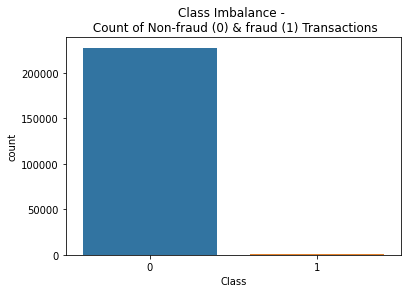

In [11]:
# plot the count of each class
sns.countplot(data=df_train, x='Class')
plt.title('Class Imbalance - \n Count of Non-fraud (0) & fraud (1) Transactions')

## Disributions


It would be useful for us to understand when popular times for transactions are and if these times are different for fraud and non-fraud transactions. Of course 'time' here is only measured as the amount of seconds since the first transaction, but this does not matter.

In a similar sense, we can also investigate the distribution of transaction amount, and again if the amounts are different for fraud and non-fraud transactions.

In [12]:
# dataframes of non-fraud and fraud rows only
nf_train = df_train[df_train['Class']==0]
f_train = df_train[df_train['Class']==1]

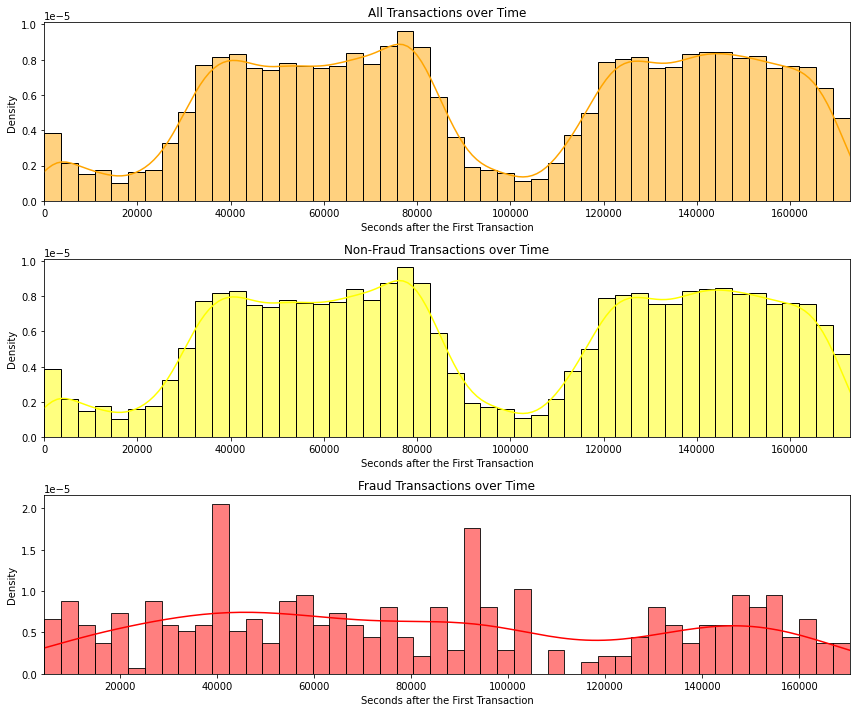

In [13]:
# Creating the graphs to plot transactions (all, non-fraud & fraud) over time

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions over time
sns.histplot(ax=ax[0], data=df_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='orange')
ax[0].set_title('All Transactions over Time')
ax[0].set_xlim(min(df_train['Time'].values), max(df_train['Time'].values))
ax[0].set_xlabel('Seconds after the First Transaction')

# Non-fraud transactions over time
sns.histplot(ax=ax[1], data=nf_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='yellow')
ax[1].set_title('Non-Fraud Transactions over Time')
ax[1].set_xlim(min(nf_train['Time'].values), max(nf_train['Time'].values))
ax[1].set_xlabel('Seconds after the First Transaction')

# Fraud transactions over time
sns.histplot(ax=ax[2], data=f_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='r')
ax[2].set_title('Fraud Transactions over Time')
ax[2].set_xlim(min(f_train['Time'].values), max(f_train['Time'].values))
ax[2].set_xlabel('Seconds after the First Transaction')

plt.tight_layout()

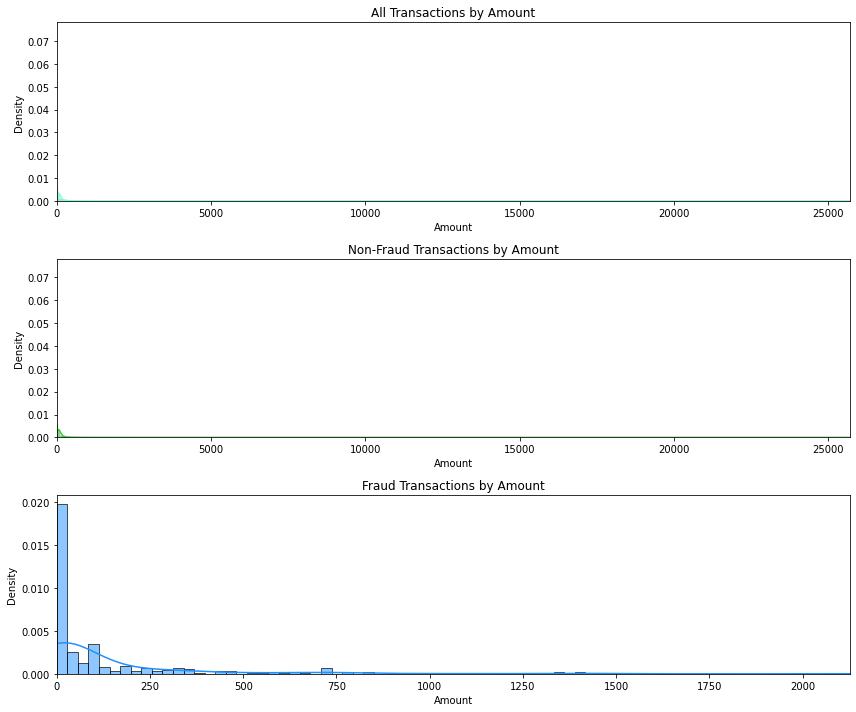

In [14]:
# Creating the graphs to plot transactions (all, non-fraud & fraud) by amount

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions by amount
sns.histplot(ax=ax[0], data=df_train, x='Amount', kde=True, stat='density', kde_kws=dict(cut=3), color='aquamarine')
ax[0].set_title('All Transactions by Amount')
ax[0].set_xlim(min(df_train['Amount'].values), max(df_train['Amount'].values))
ax[0].set_xlabel('Amount')

# Non-fraud transactions by amount
sns.histplot(ax=ax[1], data=nf_train, x='Amount', kde=True, stat='density', kde_kws=dict(cut=3), color='limegreen')
ax[1].set_title('Non-Fraud Transactions by Amount')
ax[1].set_xlim(min(nf_train['Amount'].values), max(nf_train['Amount'].values))
ax[1].set_xlabel('Amount')

# Fraud transactions by amount
sns.histplot(ax=ax[2], data=f_train, x='Amount', kde=True, stat='density', kde_kws=dict(cut=3), color='dodgerblue')
ax[2].set_title('Fraud Transactions by Amount')
ax[2].set_xlim(min(f_train['Amount'].values), max(f_train['Amount'].values))
ax[2].set_xlabel('Amount')

plt.tight_layout()

#### Transaction Times
We are going to assume that the first transaction occurred during 'evening time'. This assumption was made due to the fact that the transactions-over-time-visualisation starts with a trough (night), followed by a peak (day), followed by another trough (night again), followed by a final peak (day) before looking like it's heading towards another trough (evening).

This would make sense with the real-world as we can imagine many transactions taking place during the day, and much less happening at night. The non-fraud transactions follow the same trend.

The fraud transactions actually have a similar overall shape, most of the transactions are happening during 'day-time'. However, what is interesting is that there are much more **spikes** during the evening periods, night periods and early-morning periods - when there is a dip in non-fraud transactions.

#### Transaction Amounts
The main thing we can gather from looking at the distribution of the transaction amount is that it is heavily right-skewed. This is obviously because of the few large transaction amounts, or 'outliers', that are present in the dataset.

The right-skewness is apparent in both the non-fraud-only and fraud-only transaction data, which means that fraud transactions aren't always larger than non-fraud ones.

Let us look deeper into the transaction amount distributions and comparisons of non-fraud and fraud cases using box plots.

### Box Plots

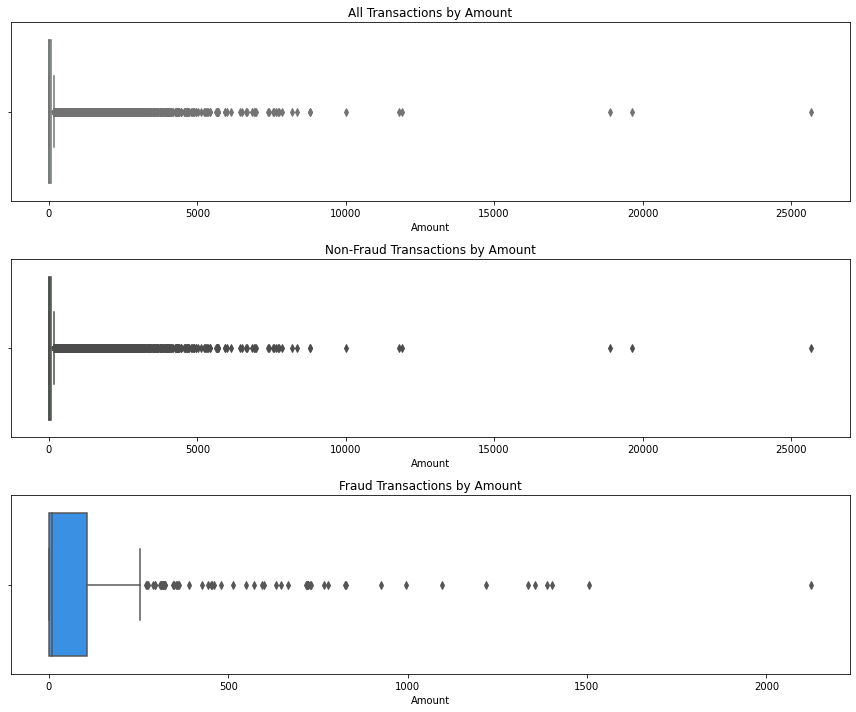

In [15]:
# Creating the box-plots of transactions (all, non-fraud & fraud) by amount

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions by amount
sns.boxplot(ax=ax[0], data=df_train, x='Amount', color='aquamarine')
ax[0].set_title('All Transactions by Amount')
ax[0].set_xlabel('Amount')

# Non-fraud transactions by amount
sns.boxplot(ax=ax[1], data=nf_train, x='Amount', color='limegreen')
ax[1].set_title('Non-Fraud Transactions by Amount')
ax[1].set_xlabel('Amount')

# Fraud transactions by amount
sns.boxplot(ax=ax[2], data=f_train, x='Amount', color='dodgerblue')
ax[2].set_title('Fraud Transactions by Amount')
ax[2].set_xlabel('Amount')

plt.tight_layout()

As we can see there are many extreme outliers that are affecting the distribution of all transaction amounts, especially non-fraud ones. We will attempt to remove these examples so that we can create a more accurate classifier. We will approach this in a way to try not to remove any fraud examples as there are so few of those in the dataset.

### Extreme Outliers
Let's investigate the IQR Method for removing outliers. The IQR method sees to it that any data more than 1.5 * the Inter-Quartile Range lower than the Lower Quartile and any data more than 1.5 * the Inter-Quartile Range higher than the Upper Quartile are removed from the dataset.

For now, we will only be performing outlier removal on the non-fraud transactions using the 'Amount'. This is because it seems that this feature's distribution seems heavily affected by outliers, as seen above, but we do not want to lose any fraud transactions here as we have such little of those.

In [16]:
print("Non-Fraud Transactions - 'Amount'")

print("\n")

# finding lower and upper quartiles and the IQR
lq = np.percentile(nf_train['Amount'], 25)
uq = np.percentile(nf_train['Amount'], 75)
iqr = uq - lq
print("Lower Quartile -", lq)
print("Upper Quartile -", uq)
print("IQR -", iqr)

print("\n")

# calculating lower and upper bounds for our outliers
lb = lq - (1.5 * iqr)
ub = uq + (1.5 * iqr)
print("Lower Bound -", lb)
print("Upper Bound -", ub)

print("\n")

# count how many non-fraud transaction amounts are below the lower bound or above the upper bound
out_count = nf_train[(nf_train['Amount'] < lb) | (nf_train['Amount'] > ub)].count()
print("Transactions below the lower bound or above the upper bound -", out_count[0])
print("Percentage of transactions that would be considered outliers using the 1.5IQR method -", round(out_count[0]/len(nf_train)*100, 2))

print("\n")

# count how many non-fraud transaction amounts are only above the upper bound
out_ub_count = nf_train[nf_train['Amount'] > ub].count()
print("Transactions above the upper bound -", out_ub_count[0])
print("Percentage of transactions that would be considered outliers above the upper bound -", round(out_ub_count[0]/len(nf_train)*100, 2))

Non-Fraud Transactions - 'Amount'


Lower Quartile - 5.68
Upper Quartile - 77.34
IQR - 71.66


Lower Bound - -101.81
Upper Bound - 184.82999999999998


Transactions below the lower bound or above the upper bound - 25499
Percentage of transactions that would be considered outliers using the 1.5IQR method - 11.21


Transactions above the upper bound - 25499
Percentage of transactions that would be considered outliers above the upper bound - 11.21


As can be seen, it doesn't look ideal to use the 1.5IQR method here for outlier removal, if we did we'd lose about 11% of our non-fraud data!

Let's use another approach - defining our own thresholds/boundaries.

Text(0, 0.5, 'Amount')

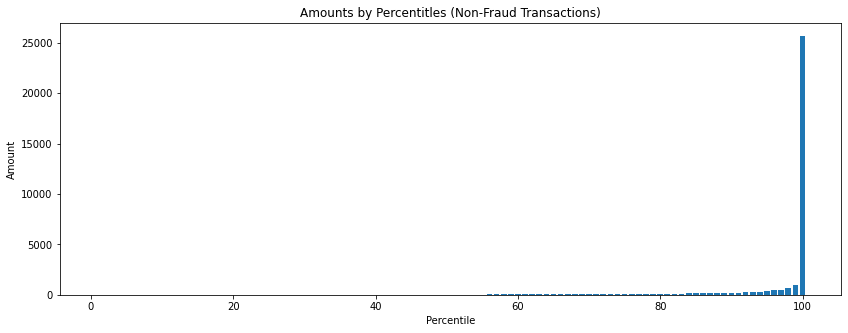

In [17]:
# gathering data for each percentile of non-fraud transaction amounts
percentiles = []
amounts = []

# p = percentile, a = amount
for p in range(1, 101):
    a = np.percentile(nf_train['Amount'], p)
    percentiles.append(p)
    amounts.append(a)
    
fig,ax = plt.subplots(1, figsize = (14, 5))
ax.bar(percentiles,amounts)
ax.set_title("Amounts by Percentitles (Non-Fraud Transactions)")
ax.set_xlabel("Percentile")
ax.set_ylabel("Amount")

Looks like even the 99th percentile doesn't include the extreme outliers we would like to be rid of in the dataset. Let's see how the data would look without the top 1% of transaction amounts.

Text(0, 0.5, 'Amount')

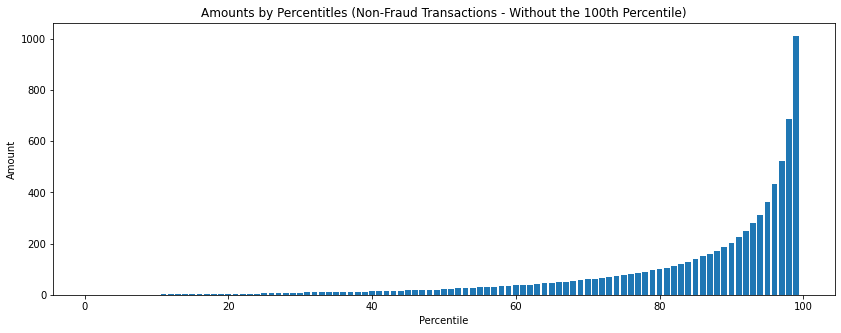

In [18]:
percentiles_99 = percentiles[0:99]
amounts_99 = amounts[0:99]

fig,ax = plt.subplots(1, figsize = (14, 5))
ax.bar(percentiles_99,amounts_99)
ax.set_title("Amounts by Percentitles (Non-Fraud Transactions - Without the 100th Percentile)")
ax.set_xlabel("Percentile")
ax.set_ylabel("Amount")

In [19]:
# what is the 99th percentile?
print(percentiles[98])
print(amounts[98])

99
1010.875


The chart is indicating that the amounts in the top 1% is indeed extreme outliers. The 99th percentile of the non-fraud data is 1010.875

#### Removal of Extreme Outliers

Let us test three approaches of removing outliers here and compare the results to a baseline classifier (without removing any outliers). The three approaches will be:
* Removal of the top 1% of transactions amounts from all transactions (both non-fraud and fraud)
* Removal of the top 1% of transaction amounts from only non-fraud transactions
* Removal of any transaction amounts larger than the largest fraud transaction

First, we need to find out what the max fraud transaction amount is.

In [20]:
f_train['Amount'].max()

2125.87

It's 2125.87.

Okay, now let's create our four datasets for comparing these approaches (including one for the base classifier).

In [21]:
df_base = df_train.copy()
df_all99 = df_base.loc[df_base['Amount'] <= 1010.875].sort_values(by='Time').reset_index(drop=True)
df_nf99 = df_base.loc[((df_base['Class'] == 0) & (df_base['Amount'] <= 1010.875)) | df_base['Class'] == 1].sort_values(by='Time').reset_index(drop=True)
df_maxf = df_base.loc[df_base['Amount'] <= 2125.87].sort_values(by='Time').reset_index(drop=True)

out_rems = {
    'baseline': {'df': df_base},
    'all_99': {'df': df_all99},
    'non_fraud_99': {'df': df_nf99},
    'max_fraud_amount': {'df': df_maxf}
}

In order we will now:
1. Create a dictionary to hold the features and targets of all of our datasets
2. For each dataset, scale the 'Amount' and 'Time' features
3. Perform Random Undersampling (explained later) on each dataset
4. Create a Logistic Regression Model for each dataset
5. Perform Cross Validation on each model using each dataset
6. Save and compare the Recall and F1 scores

In [22]:
# for each approach
for key in out_rems:
    approach = key
    X_out = out_rems[approach]['df'].drop('Class', axis=1)
    y_out = out_rems[approach]['df']['Class']
    
    # scale the 'amount' and 'time' features
    rbs = RobustScaler()
    col_names = ['Amount', 'Time']
    scaled_features = rbs.fit_transform(X_out[col_names].values)
    X_out[col_names] = scaled_features
    
    # perform random undersampling on the data
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X_out, y_out)
    df_out = pd.concat([X_rus, y_rus], axis=1).sort_values(by='Time').reset_index(drop=True)
    X_out = df_out.drop('Class', axis=1)
    y_out = df_out['Class']
    
    # create a logreg model
    model = LogisticRegression(max_iter=1000)
    
    # start cross-val
    start = time.time()
    
    y_pred = cross_val_predict(model, X_out, y_out, cv=5)
    
    recall = recall_score(y_out, y_pred)
    accuracy = accuracy_score(y_out, y_pred)
    specificity = recall_score(y_out, y_pred, pos_label=0)
    cf = confusion_matrix(y_out, y_pred)
    end = time.time()
    
    out_rems[approach]['df'] = df_out
    out_rems[approach]['X'] = X_out
    out_rems[approach]['y'] = y_out
    
    print(approach)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    print("Recall score -", recall)
    print("Accuracy score -", accuracy)
    print("Specificity score -", specificity)
    print("Confusion Matrix -\n", cf)
    print("\n")

baseline
Completed in 0.213 seconds.
Recall score - 0.8883248730964467
Accuracy score - 0.9137055837563451
Specificity score - 0.9390862944162437
Confusion Matrix -
 [[370  24]
 [ 44 350]]


all_99
Completed in 0.196 seconds.
Recall score - 0.8886010362694301
Accuracy score - 0.9248704663212435
Specificity score - 0.961139896373057
Confusion Matrix -
 [[371  15]
 [ 43 343]]


non_fraud_99
Completed in 0.197 seconds.
Recall score - 0.8934010152284264
Accuracy score - 0.9289340101522843
Specificity score - 0.9644670050761421
Confusion Matrix -
 [[380  14]
 [ 42 352]]


max_fraud_amount
Completed in 0.207 seconds.
Recall score - 0.883248730964467
Accuracy score - 0.9213197969543148
Specificity score - 0.9593908629441624
Confusion Matrix -
 [[378  16]
 [ 46 348]]




From the results, it seems that just removing the top 1% as outliers for only non-fraud transactions yielded the best results. Therefore, we will go with this approach.

In [23]:
df_train = df_nf99

In [24]:
# dataframes of non-fraud and fraud rows only
nf_train = df_train[df_train['Class']==0]
f_train = df_train[df_train['Class']==1]

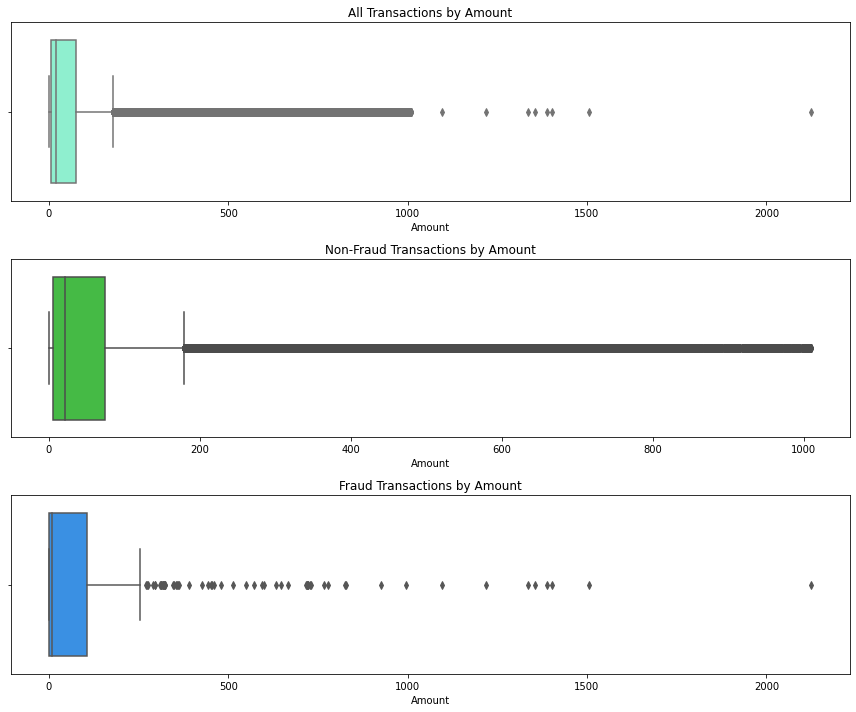

In [25]:
# Creating the NEW box-plots of transactions (all, non-fraud & fraud) by amount

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions by amount
sns.boxplot(ax=ax[0], data=df_train, x='Amount', color='aquamarine')
ax[0].set_title('All Transactions by Amount')
ax[0].set_xlabel('Amount')

# Non-fraud transactions by amount
sns.boxplot(ax=ax[1], data=nf_train, x='Amount', color='limegreen')
ax[1].set_title('Non-Fraud Transactions by Amount')
ax[1].set_xlabel('Amount')

# Fraud transactions by amount
sns.boxplot(ax=ax[2], data=f_train, x='Amount', color='dodgerblue')
ax[2].set_title('Fraud Transactions by Amount')
ax[2].set_xlabel('Amount')

plt.tight_layout()

## Feature Correlations

Let us attempt to understand the correlations between the anonymous features, and our target variable.

Text(0.5, 1.0, 'Correlation Matrix')

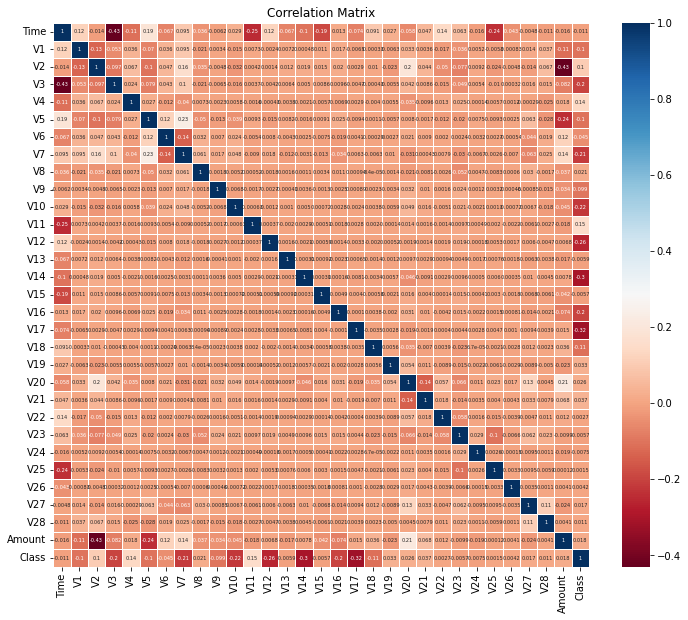

In [26]:
# Plotting the correlation matrix of all features

fig, ax = plt.subplots(figsize=(12, 10))

corr = df_train.corr()

sns.heatmap(ax=ax, data=corr, annot=True, annot_kws={'size':5}, xticklabels=True, yticklabels=True, linewidths=1, cmap='RdBu')
ax.set_title('Correlation Matrix')

It looks like there are some note-worthy correlated features such as V17, V14 and V12 (all negative), but this correlation matrix may be not ideal to utilise. This is because feature correlations are not very accurate and do not show as much when the data is imbalanced, which is the case here. Therefore, we will compute another correlation matrix for analysis once we have addressed the imbalance issues.

It's also worth mentioning that none of the features look like they strongly correlate with each other.

# Re-sampling
We have already discussed the problem of class imbalance. In our dataset, less than 1% of the data is of the minority class, the class we would like to make sure we predict well. If we use the original dataset as is to train our model, it will struggle in performing this task. A very common and popular method in aiding with this type of situation is re-sampling. Two ways in which re-sampling can be done are *oversampling* and *undersampling*.

#### Oversampling
Oversampling involves creating more examples of the minority class. This will increase the ratio of that class in the dataset to make it more balanced. There are multiple methods of oversampling commonly used:
* Random oversampling - adding copies of examples in the minority class, chosen randomly.
* SMOTE (Synthetic Minority Over-sampling Technique) & variations - probably the most used, this method involves creating synthetic examples in between existing examples (in their feature space) of the minority class.
* ADASYN (ADAptive SYNthetic sampling approach) - similar to SMOTE, creates synthetic examples in the minority class similar to those that already exist that are difficult to learn by the model.

#### Undersampling
Undersampling would be to remove examples of the majority class until the dataset is sufficiently balanced between both classes. There are many undersampling methods:
* Random undersampling - randomly removing examples of the majority class.
* Cluster - reducing clusters of samples to just the centroid example of that cluster.
* Tomek Link - removes examples of the majority class that are closer/overlapping to another class than its own class neighbours (AKA removing 'noise', or removing examples near a border). This can be seen as a method that removes 'noise', such as overlapping examples/borders. The examples removed are generally of the majority class which may prove useful in cases where recall for the minority class is more important, such as ours.

There are other undersampling methods, such as NearMiss, Condensed-Nearest-Neighbour (CNN), Edited-Nearest-Neighbour (ENN) etc. but we will not be looking at those. I would have personally liked to try CNN but the algorithm is very slow to implement so I will look to use it in a future update (I actually tried NearMiss in another draft and, although the recall scores were good, the specificity scores were bad meaning they would cause more missclassification of non-fraud transactions).

Because our minority examples are so few (492 in the original dataset) and our majority examples are so many (284315 in the original dataset), we will utilise **undersampling**. This approach here will be much simpler, much less computationally expensive, and won't be burdened with a massive amount of copied/synthetic data.

However, before continuing, we need to scale our 'Amount' and 'Time' features. The PCA transformed columns (V1-V28) have all undergone scaling already.

### Scaling
We will use the robust scaler method insead of standard scaler as it is recommended for when there are outliers in the data (which we have a lot of!).

In [27]:
# creating a copy to do analysis with scaling and re-sampling
df_sres = df_train.copy()

col_names = ['Amount', 'Time']
features = df_sres[col_names]

# scaling the amount and time features
scaler = RobustScaler()
features = scaler.fit_transform(features.values)

df_sres[col_names] = features

## Undersampling
Let's createmore balanced datasets of the two classes using the undersampling methods we mentioned above.

In [28]:
X_sres = df_sres.drop('Class', axis=1)
y_sres = df_sres['Class']

print(df_sres['Class'].value_counts()[0])
print(df_sres['Class'].value_counts()[1])
# original amounts

225176
394


In [29]:
usamplers = {
    'rus': {'sampler': RandomUnderSampler(random_state=42)},
    'cc': {'sampler': ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)},
    'tl': {'sampler': TomekLinks()}
}

for key in usamplers:
    start = time.time()
    
    resampler = usamplers[key]['sampler']
    res_X, res_Y = resampler.fit_resample(X_sres, y_sres)
    
    usamplers[key]['df'] = pd.concat([res_X, res_Y], axis=1).sort_values(by='Time').reset_index(drop=True)
    usamplers[key]['X'] = usamplers[key]['df'].drop('Class', axis=1)
    usamplers[key]['y'] = usamplers[key]['df']['Class']
    
    end = time.time()
    
    print(key)
    print("Completed in", round((end - start), 3), "seconds.")
    print("Non-fraud examples -", usamplers[key]['df']['Class'].value_counts()[0])
    print("Fraud examples -", usamplers[key]['df']['Class'].value_counts()[1])
    print("\n")

# Using Tomek Links won't create a 50:50 split of the classes
# We will combine this method with the others.

tl_usamplers = {
    'tl_rus': {'sampler': RandomUnderSampler(random_state=42)},
    'tl_cc': {'sampler': ClusterCentroids(estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)},
}

for key in tl_usamplers:
    start = time.time()
    
    resampler = tl_usamplers[key]['sampler']
    pre_X = usamplers['tl']['X']
    pre_y = usamplers['tl']['y']
    res_X, res_Y = resampler.fit_resample(pre_X, pre_y)
    
    tl_usamplers[key]['df'] = pd.concat([res_X, res_Y], axis=1).sort_values(by='Time').reset_index(drop=True)
    tl_usamplers[key]['X'] = tl_usamplers[key]['df'].drop('Class', axis=1)
    tl_usamplers[key]['y'] = tl_usamplers[key]['df']['Class']
    
    end = time.time()
    
    print(key)
    print("Completed in", round((end - start), 3), "seconds.")
    print("Non-fraud examples -", tl_usamplers[key]['df']['Class'].value_counts()[0])
    print("Fraud examples -", tl_usamplers[key]['df']['Class'].value_counts()[1])
    print("\n")
    
# Let us also attempt using the Tomek Links method after Random Under Sampler and Cluster Centroids

tl_after_usamplers = {
    'rus_tl': {'sampler': TomekLinks(), 'pre_sampler': 'rus'},
    'cc_tl': {'sampler': TomekLinks(), 'pre_sampler': 'cc'}
}

for key in tl_after_usamplers:
    start = time.time()
    
    resampler = tl_after_usamplers[key]['sampler']
    pre_sampler = tl_after_usamplers[key]['pre_sampler']
    pre_X = usamplers[pre_sampler]['X']
    pre_y = usamplers[pre_sampler]['y']
    res_X, res_Y = resampler.fit_resample(pre_X, pre_y)
    
    tl_after_usamplers[key]['df'] = pd.concat([res_X, res_Y], axis=1).sort_values(by='Time').reset_index(drop=True)
    tl_after_usamplers[key]['X'] = tl_after_usamplers[key]['df'].drop('Class', axis=1)
    tl_after_usamplers[key]['y'] = tl_after_usamplers[key]['df']['Class']
    
    end = time.time()
    
    print(key)
    print("Completed in", round((end - start), 3), "seconds.")
    print("Non-fraud examples -", tl_after_usamplers[key]['df']['Class'].value_counts()[0])
    print("Fraud examples -", tl_after_usamplers[key]['df']['Class'].value_counts()[1])
    print("\n")

rus
Completed in 0.052 seconds.
Non-fraud examples - 394
Fraud examples - 394


cc
Completed in 1.446 seconds.
Non-fraud examples - 394
Fraud examples - 394


tl
Completed in 622.344 seconds.
Non-fraud examples - 225156
Fraud examples - 394


tl_rus
Completed in 0.049 seconds.
Non-fraud examples - 394
Fraud examples - 394


tl_cc
Completed in 1.321 seconds.
Non-fraud examples - 394
Fraud examples - 394


rus_tl
Completed in 0.031 seconds.
Non-fraud examples - 394
Fraud examples - 383


cc_tl
Completed in 0.032 seconds.
Non-fraud examples - 394
Fraud examples - 383




Now let's compare which undersampling method gives the best results.

In [30]:
# dictionary to save each dataset and model
usample_models = {
    'rus': {},
    'cc': {},
    'tl_rus': {},
    'tl_cc': {},
    'rus_tl': {},
    'cc_tl': {}
}

# for each undersampling method
for key in usample_models:
    method = key
    if method in list(usamplers.keys()):
        usample_models[method] = usamplers[method]
    elif method in list(tl_usamplers.keys()):
        usample_models[method] = tl_usamplers[method]
    elif method in list(tl_after_usamplers.keys()):
        usample_models[method] = tl_after_usamplers[method]
    
    # using log reg model
    model = LogisticRegression(max_iter=1000)
    X_res = usample_models[method]['X'].values
    y_res = usample_models[method]['y'].values.ravel()
    
    # start cross-val
    start = time.time()
    
    y_pred = cross_val_predict(model, X_res, y_res, cv=7)

    recall = recall_score(y_res, y_pred)
    accuracy = accuracy_score(y_res, y_pred)
    specificity = recall_score(y_res, y_pred, pos_label=0)
    cf = confusion_matrix(y_res, y_pred)
    
    end = time.time()

    print(method)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    print("Recall score -", round(recall, 3))
    print("Accuracy -", round(accuracy, 3))
    print("Specificity Score -", round(specificity, 3))
    print("Confusion Matrix -\n", cf)
    print("\n")

rus
Completed in 0.258 seconds.
Recall score - 0.914
Accuracy - 0.938
Specificity Score - 0.962
Confusion Matrix -
 [[379  15]
 [ 34 360]]


cc
Completed in 0.28 seconds.
Recall score - 0.911
Accuracy - 0.945
Specificity Score - 0.98
Confusion Matrix -
 [[386   8]
 [ 35 359]]


tl_rus
Completed in 0.259 seconds.
Recall score - 0.911
Accuracy - 0.925
Specificity Score - 0.939
Confusion Matrix -
 [[370  24]
 [ 35 359]]


tl_cc
Completed in 0.312 seconds.
Recall score - 0.911
Accuracy - 0.944
Specificity Score - 0.977
Confusion Matrix -
 [[385   9]
 [ 35 359]]


rus_tl
Completed in 0.235 seconds.
Recall score - 0.94
Accuracy - 0.955
Specificity Score - 0.97
Confusion Matrix -
 [[382  12]
 [ 23 360]]


cc_tl
Completed in 0.306 seconds.
Recall score - 0.927
Accuracy - 0.959
Specificity Score - 0.99
Confusion Matrix -
 [[390   4]
 [ 28 355]]




We are focusing on recall first (which will be discussed later), so based on this, it looks like the best performing undersampling methods (although all similar), in order, are:
1. Random Undersampling -> Tomek Links
2. Cluser Centroids -> Tomek Links
3. Random Undersampling
4. Cluster Centroids
5. Tomek Links -> Cluster Centroids
6. Tomek Links -> Random Undersampling

### Random Undersampling -> Tomek Links
Now let's create our new resampled (and scaled) training dataframe.

In [31]:
res_train = usample_models['rus_tl']['df']

X_res_train = usample_models['rus_tl']['X']
y_res_train = usample_models['rus_tl']['y']

### EDA...again
First let's look at our new nicely even distributed classes.

Text(0.5, 1.0, 'Class Imbalance - \n Count of Non-fraud (0) & fraud (1) Transactions')

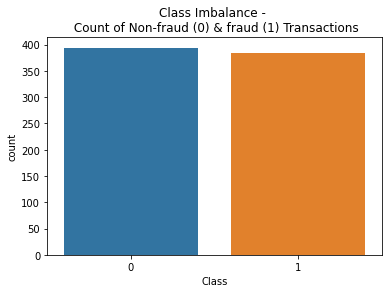

In [32]:
# plot the count of each class
sns.countplot(data=res_train, x='Class')
plt.title('Class Imbalance - \n Count of Non-fraud (0) & fraud (1) Transactions')

Beautiful! Now let's look at the distributions of the 'Time' and 'Amount' features again, this time with our scaled and re-sampled data.

In [33]:
# re-sampled dataframes of non-fraud and fraud rows only
nf_res_train = res_train[res_train['Class']==0]
f_res_train = res_train[res_train['Class']==1]

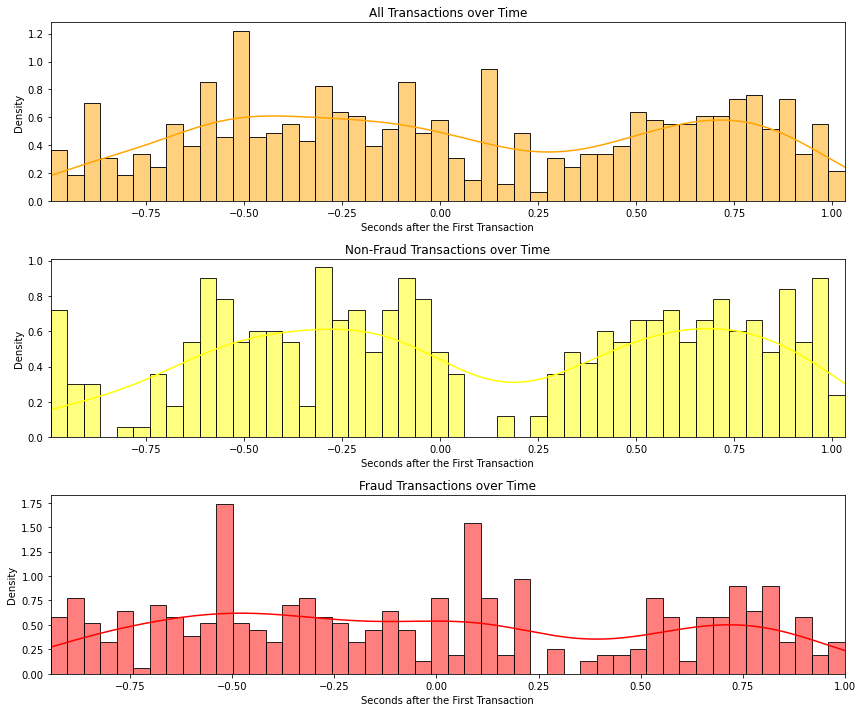

In [34]:
# Creating the graphs to plot transactions (all, non-fraud & fraud) over time

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions over time
sns.histplot(ax=ax[0], data=res_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='orange')
ax[0].set_title('All Transactions over Time')
ax[0].set_xlim(min(res_train['Time'].values), max(res_train['Time'].values))
ax[0].set_xlabel('Seconds after the First Transaction')

# Non-fraud transactions over time
sns.histplot(ax=ax[1], data=nf_res_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='yellow')
ax[1].set_title('Non-Fraud Transactions over Time')
ax[1].set_xlim(min(nf_res_train['Time'].values), max(nf_res_train['Time'].values))
ax[1].set_xlabel('Seconds after the First Transaction')

# Fraud transactions over time
sns.histplot(ax=ax[2], data=f_res_train, x='Time',bins=48, kde=True, stat='density', kde_kws=dict(cut=3), color='r')
ax[2].set_title('Fraud Transactions over Time')
ax[2].set_xlim(min(f_res_train['Time'].values), max(f_res_train['Time'].values))
ax[2].set_xlabel('Seconds after the First Transaction')

plt.tight_layout()

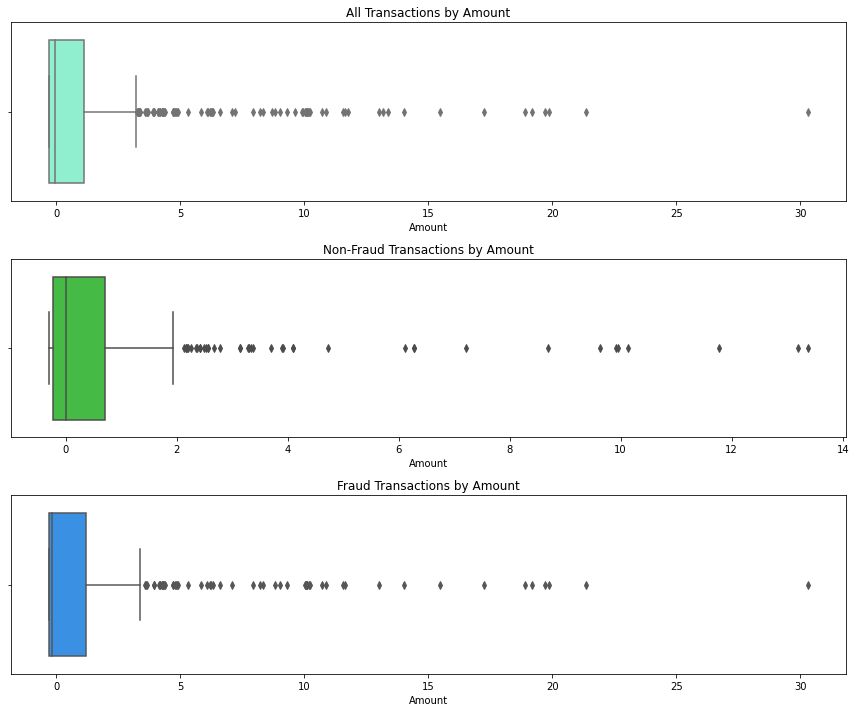

In [35]:
# Creating the box-plots of transactions (all, non-fraud & fraud) by amount

fig, ax = plt.subplots(3, figsize=(12, 10))

# All transactions by amount
sns.boxplot(ax=ax[0], data=res_train, x='Amount', color='aquamarine')
ax[0].set_title('All Transactions by Amount')
ax[0].set_xlabel('Amount')

# Non-fraud transactions by amount
sns.boxplot(ax=ax[1], data=nf_res_train, x='Amount', color='limegreen')
ax[1].set_title('Non-Fraud Transactions by Amount')
ax[1].set_xlabel('Amount')

# Fraud transactions by amount
sns.boxplot(ax=ax[2], data=f_res_train, x='Amount', color='dodgerblue')
ax[2].set_title('Fraud Transactions by Amount')
ax[2].set_xlabel('Amount')

plt.tight_layout()

The 'Amount' data is still heavily right-skewed, and especially non-fraud transactions are affected by extreme outliers.

Now let's recreate the correlation matrix! It should be much more telling this time.

#### The REAL Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

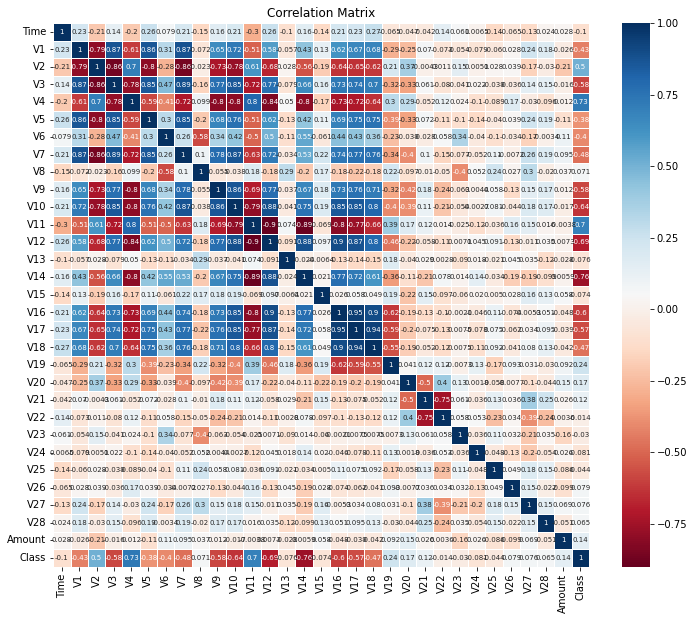

In [36]:
# Plotting the correlation matrix of all features

fig, ax = plt.subplots(figsize=(12, 10))

corr = res_train.corr()

sns.heatmap(ax=ax, data=corr, annot=True, annot_kws={'size':7}, xticklabels=True, yticklabels=True, linewidths=1, cmap='RdBu')
ax.set_title('Correlation Matrix')

See? Much better! We can see the most interesting (highly correlated) features are:
* V14 (Negative)
* V4 (Positive)
* V11 (Positive)
* V12 (Negative)
* V10 (Negative)

Let's look at the distribution for these features. Note that because the features were scaled for PCA transformation, their distributions for non-fraud examples will just follow a normal distribution with a mean of 0, so we will look at the distributions for fraud examples only.

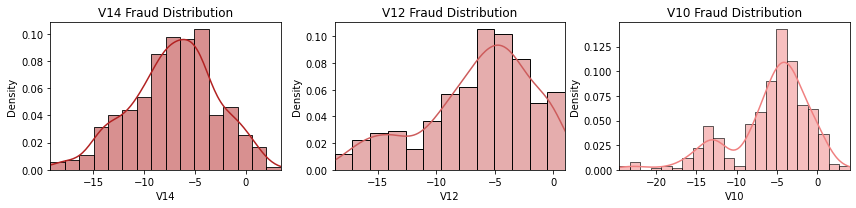

In [37]:
# Creating the graphs to plot negatively correlated features distributions

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

# V14
sns.histplot(ax=ax[0], data=f_res_train, x='V14', kde=True, stat='density', kde_kws=dict(cut=3), color='firebrick')
ax[0].set_title('V14 Fraud Distribution')
ax[0].set_xlim(min(f_res_train['V14'].values), max(f_res_train['V14'].values))

# V14
sns.histplot(ax=ax[1], data=f_res_train, x='V12', kde=True, stat='density', kde_kws=dict(cut=3), color='indianred')
ax[1].set_title('V12 Fraud Distribution')
ax[1].set_xlim(min(f_res_train['V12'].values), max(f_res_train['V12'].values))

# V14
sns.histplot(ax=ax[2], data=f_res_train, x='V10', kde=True, stat='density', kde_kws=dict(cut=3), color='lightcoral')
ax[2].set_title('V10 Fraud Distribution')
ax[2].set_xlim(min(f_res_train['V10'].values), max(f_res_train['V10'].values))

plt.tight_layout()

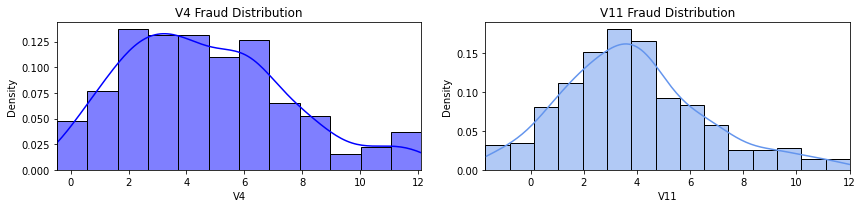

In [38]:
# Creating the graphs to plot positively correlated features distributions

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# V4
sns.histplot(ax=ax[0], data=f_res_train, x='V4', kde=True, stat='density', kde_kws=dict(cut=3), color='blue')
ax[0].set_title('V4 Fraud Distribution')
ax[0].set_xlim(min(f_res_train['V4'].values), max(f_res_train['V4'].values))

# V11
sns.histplot(ax=ax[1], data=f_res_train, x='V11', kde=True, stat='density', kde_kws=dict(cut=3), color='cornflowerblue')
ax[1].set_title('V11 Fraud Distribution')
ax[1].set_xlim(min(f_res_train['V11'].values), max(f_res_train['V11'].values))

plt.tight_layout()

They all (positive and negative correlated features) also follow a bell-curve shaped distribution. However, the more negatively correlated to the class the feature is, the lower the mean is (lower than 0), and the more positively correlated to the class the feature is, the higher the mean is (larger than 0).

#### Box Plots for Correlated Features
We can verify the above observations better with box plots.

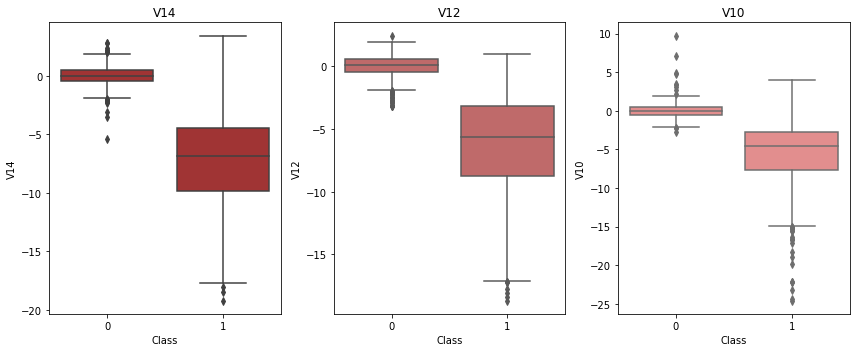

In [39]:
# Creating the box-plots of negatively correlated features

fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# V14
sns.boxplot(ax=ax[0], data=res_train, x='Class', y='V14', color='firebrick')
ax[0].set_title('V14')

# V12
sns.boxplot(ax=ax[1], data=res_train, x='Class', y='V12', color='indianred')
ax[1].set_title('V12')

# V10
sns.boxplot(ax=ax[2], data=res_train, x='Class', y='V10', color='lightcoral')
ax[2].set_title('V10')

plt.tight_layout()

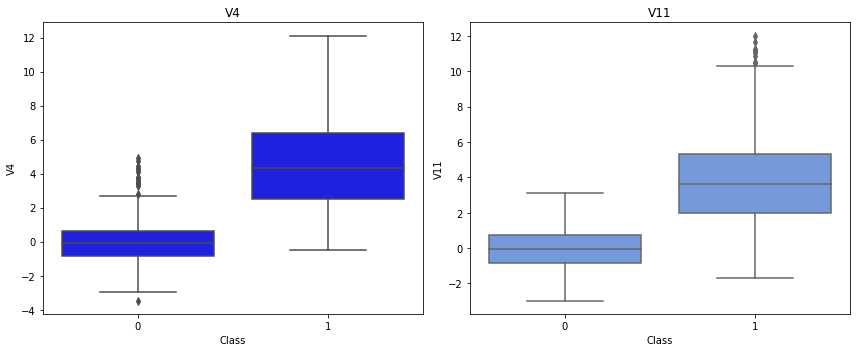

In [40]:
# Creating the box-plots of negatively correlated features

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# V14
sns.boxplot(ax=ax[0], data=res_train, x='Class', y='V4', color='blue')
ax[0].set_title('V4')

# V12
sns.boxplot(ax=ax[1], data=res_train, x='Class', y='V11', color='cornflowerblue')
ax[1].set_title('V11')

plt.tight_layout()

# Data Visualisation

If we tried to visualise our data now to see the clusters of our two classes, it would be impossible due to the amout of features (30). We would need the capability to see in 30-d space to plot the data. However, we can use the technique of dimensionality reduction for this purpose.

## Dimensionality Reduction for Data Visualisation

It is not uncommon to reduce the number of features to represent the data so that we can plot them in 3-d or 2-d graphs for visualisation purposes, such as the aim here.

There are a few techniques that can be used here such as:
* PCA (Principal Component Analysis) (like used to anonymise the original features of the dataset)
* t-SNE (t-distributed Stochastic Neighbour Embedding)
* MDS (Multidimensional Scaling)
* LLE (Locally Linear Embedding)

### PCA
PCA projects a dataset from higher dimensional space to lower dimensional space by finding the direction in which the data has the most variance (spread). The first dimension would be the direction with the highest variance, then the second dimension would be the direction with the next highest variance that is also othorgonal (at a right degree angle) to the first dimension, and so on until the number of dimensions pre-defined is satisfied. This method ensures minum information loss by picking the directions with the highest variance.

Since PCA is the most common dimensionality reduction method. Let's use it here to try and visualise our dataset.

In [41]:
start = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_res_train.values)
end = time.time()

print("PCA completed in", round((round((end - start), 3)), 3), "seconds.")

df_pca = pd.DataFrame(data=X_pca, columns=['pc1', 'pc2'])
df_pca['Class'] = y_res_train

PCA completed in 0.033 seconds.


Text(0, 0.5, 'Principal Component 2')

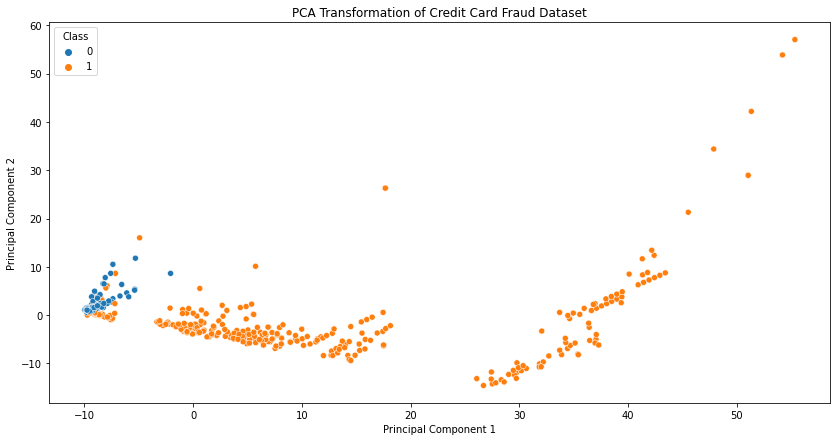

In [42]:
fig, ax = plt.subplots(1, figsize=(14, 7))

sns.scatterplot(data=df_pca, x='pc1', y='pc2', hue='Class', ax=ax)
ax.set_title('PCA Transformation of Credit Card Fraud Dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

As we can see the non-fraud transactions have been densely clustered together, with fraud trasnactions more spread out. However, we can't linearly separate both the clusters well. Let's try another dimensionality reduction technique that is much better at linearly separating clusters.

### t-SNE

In [43]:
start = time.time()
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', perplexity=50)
X_tsne = tsne.fit_transform(X_res_train.values)
end = time.time()

print("t-SNE ompleted in", round((round((end - start), 3)), 3), "seconds.")

df_tsne = pd.DataFrame(data=X_tsne, columns=['tsne1', 'tsne2'])
df_tsne['Class'] = y_res_train

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


t-SNE ompleted in 7.106 seconds.


Text(0.5, 1.0, 't-SNE Transformation of Credit Card Fraud Dataset')

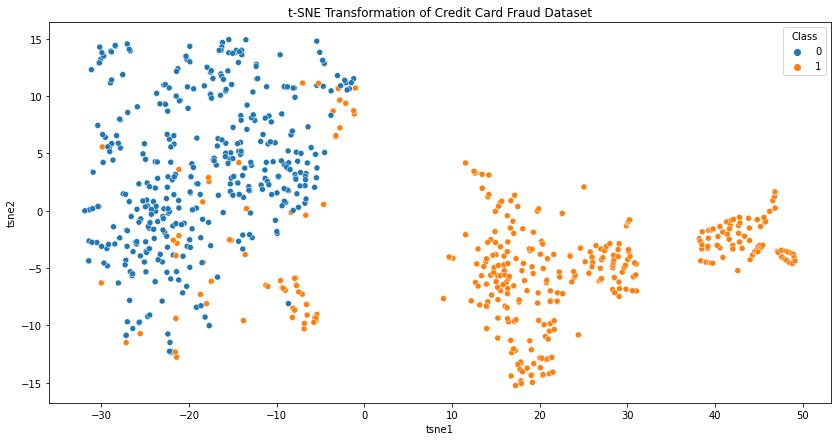

In [44]:
fig, ax = plt.subplots(1, figsize=(14, 7))

sns.scatterplot(data=df_tsne, x='tsne1', y='tsne2', hue='Class', ax=ax)
ax.set_title('t-SNE Transformation of Credit Card Fraud Dataset')

This method clearly separates the two class clusters, obviously there are some overlaps but the naked eye can easily spot the two clusters.

As a comparison, let's plot the dimensionality reduction clustering attempts from using MDS, Isomap and LLE.

In [45]:
# MDS
start = time.time()
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X_res_train.values)
end = time.time()

print("MDS completed in", round((round((end - start), 3)), 3), "seconds.")

df_mds = pd.DataFrame(data=X_mds, columns=['mds1', 'mds2'])
df_mds['Class'] = y_res_train

# LLE
start = time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42, eigen_solver='dense')
X_lle = lle.fit_transform(X_res_train.values)
end = time.time()

print("LLE completed in", round((round((end - start), 3)), 3), "seconds.")

df_lle = pd.DataFrame(data=X_lle, columns=['lle1', 'lle2'])
df_lle['Class'] = y_res_train

MDS completed in 14.889 seconds.
LLE completed in 0.229 seconds.


Text(0.5, 1.0, 'LLE Transformation of Credit Card Fraud Dataset')

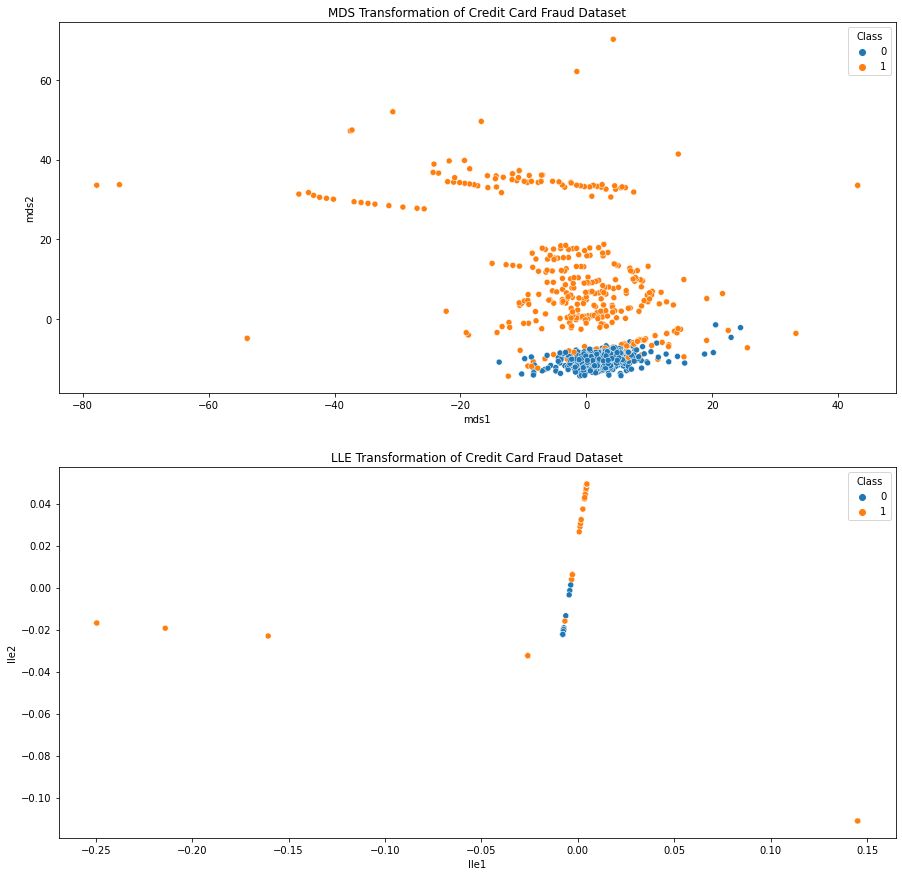

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# MDS
sns.scatterplot(data=df_mds, x='mds1', y='mds2', hue='Class', ax=ax[0])
ax[0].set_title('MDS Transformation of Credit Card Fraud Dataset')

# LLE
sns.scatterplot(data=df_lle, x='lle1', y='lle2', hue='Class', ax=ax[1])
ax[1].set_title('LLE Transformation of Credit Card Fraud Dataset')

These are all less ideal to visualise our data than the t-SNE plot.

# Classification Models

We have now entered the fun part of this project. Creating our models! Let's begin with some basic classifiers:
1. Logistic Regression
2. Support Vector Machine (SVM)
3. Decision Tree
4. Naive Bayes
5. K-Nearest-Neighbour (KNN)



Note - for all scores in this section, I will save them to a dictionary of scores to assess at the end. I will also save the classifiers in a separate dictionary as reference.

In [47]:
scores_data = {
    'scores': ['recall', 'accuracy', 'specificity', 'precision', 'f1']
}

classifiers = {}

In [48]:
# function for plotting confusion matrix
def visualise_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.YlOrBr)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    plt.title(title)
    plt.show()
    
# function for plotting the scores in a table
def plot_score_table(recall, accuracy, specificity, precision, f1):
    recall_rounded = round(recall, 3)
    accuracy_rounded = round(accuracy, 3)
    specificity_rounded = round(specificity, 3)
    precision_rounded = round(precision, 3)
    f1_rounded = round(f1, 3)
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=[[recall_rounded, accuracy_rounded, specificity_rounded, precision_rounded, f1_rounded]],
                         colLabels=['Recall', 'Accuracy', 'Specificity', 'Precision', 'F1'],
                         loc='center')
    plt.show()

base_LogReg
Completed in 0.344 seconds.


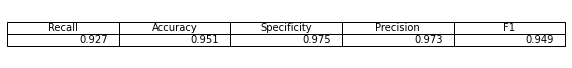

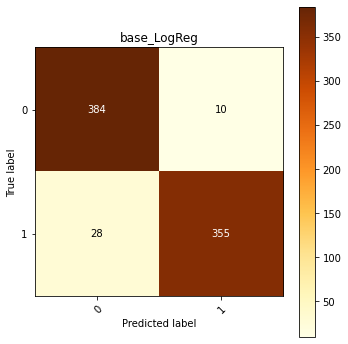



base_SVM
Completed in 0.119 seconds.


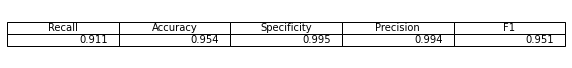

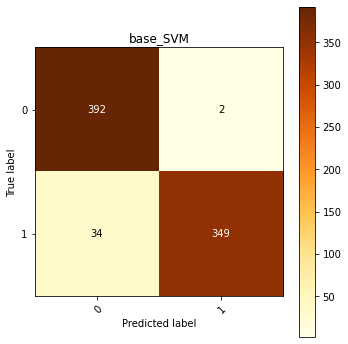



base_DT
Completed in 0.131 seconds.


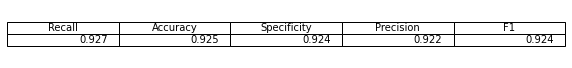

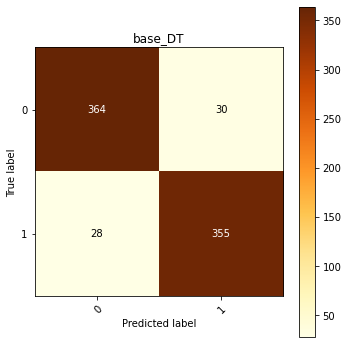



base_NB
Completed in 0.021 seconds.


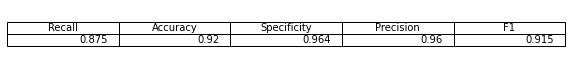

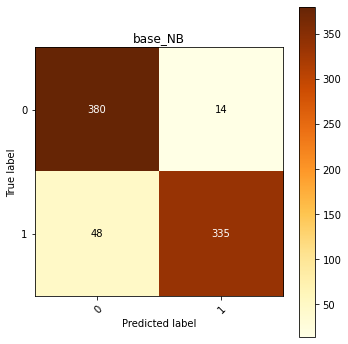

In [49]:
base_classifiers = {
    'base_LogReg': LogisticRegression(random_state=42),
    'base_SVM': SVC(random_state=42),
    'base_DT': DecisionTreeClassifier(random_state=42),
    'base_NB': GaussianNB()
}

for key, value in base_classifiers.items():
    clf = value

    # start cross-val
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=10)

    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")

scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [50]:
scores_df

,recall,accuracy,specificity,precision,f1
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951


## Scores

You can see the order I have put the scores. To me, it makes sense for the scores to matter in this order, why? Let's break it down.

Our main aim is to detect fraud transactions. **Recall** ensures the assessment of this for us. If recall was 1, that means we detected all of the fraud transactions there are correctly.

However, what if we just classify all of our transactions as fraud? We will still have recall of 1, but our model is no good if it's missclassifying non-fraud transactions as fraud. It will be bothersome. There, we can look at **specificity**. A High specificity ensures that we are classifying the negative label (non-fraud transactions) correctly. So really, a high recall and specificity are the two most important goals we care about.

**Accuracy** is a measure of how many of our predicions we are getting right out of all transactions. In a sense, it is sort of like recall and specificity together, but if two models have the same accuracy, but different recalls and specificity, we would care about the one with higher recall.

We do not care so much for *precision* and *f1* score (which takes into consideration precision), because of all the non-fraud transactions, it only takes into account those that we incorrectly classified and not the ones that we correctly classified (like specificity does). This means that if we are overcompensating and classifying some percentage of non-fraud transactions as fraud, getting them wrong, then we will get a low precision score. I will explain more later about why a low precision score may not be so bad if this does not make sense to you now.

Naive Bayes is our worst performing classifier so we will drop this here. We'll fine-tune the rest to see if we can get a higher recall and accuracy score, as well as looking at the KNN algorithm.

## Fine-Tuning

We will now start using grid search to find tune our base models to improve our scores.

For each model menioned above, we will grid search for the best hyper-parameters and let the best hyper-parameter combinations be found using recall. Each model will then be used with its best hyper-parameters (using gridsearchCV's best_estimator_) to retrain on the training set using cross validation so that we can get the other scores too (specifically accuracy and specificity, our two most important scores). That way we can properly assess each model.

Grid Search completed in 4.999 seconds.
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
fine_tuned_KNN
Completed in 0.038 seconds.


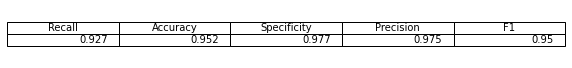

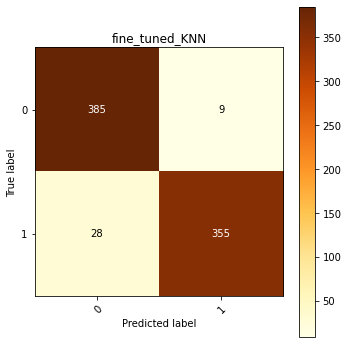

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

Grid Search completed in 1.228 seconds.
{'C': 0.1, 'penalty': 'l2'}
fine_tuned_LogReg
Completed in 0.103 seconds.


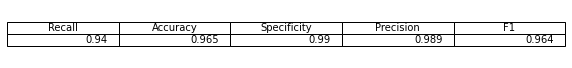

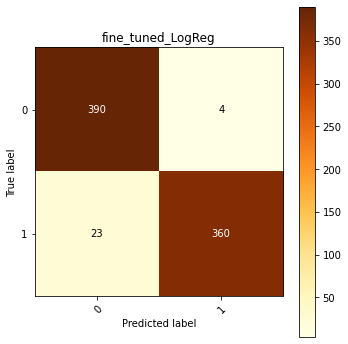



Grid Search completed in 12.354 seconds.
{'C': 100, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
fine_tuned_SVM
Completed in 0.117 seconds.


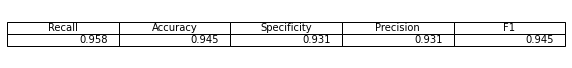

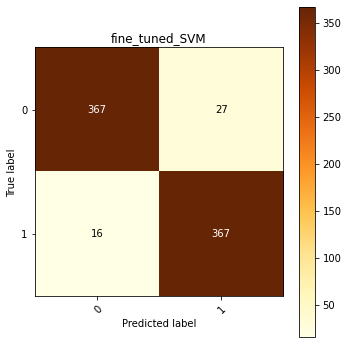



Grid Search completed in 0.727 seconds.
{'max_depth': 7, 'min_samples_leaf': 1}
fine_tuned_DT
Completed in 0.054 seconds.


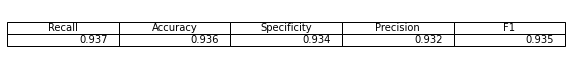

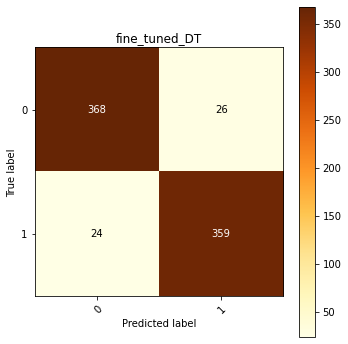

In [51]:
fine_tune_classifiers = {
    'fine_tuned_KNN': {
        'clf': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [1, 3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'p': [1, 2, 3]
        },
    },
    'fine_tuned_LogReg': {
        'clf': LogisticRegression(random_state=42, max_iter=500),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2']
        }
    },
    'fine_tuned_SVM': {
        'clf': SVC(random_state=42),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
        }
    },
    'fine_tuned_DT': {
        'clf': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'max_depth': [3, 5, 7, 9],
            'min_samples_leaf': [1, 3, 5, 7]
        }
    }
}

for key, value in fine_tune_classifiers.items():
    classifier = value

    # start grid search
    start = time.time()
    grid_search = GridSearchCV(classifier['clf'], classifier['param_grid'], cv=5, scoring='recall')
    grid_search.fit(X_res_train.values, y_res_train.values.ravel())
    end = time.time()
    print("Grid Search completed in", round((round((end - start), 3)), 3), "seconds.")
    print(grid_search.best_params_)
    
    clf = grid_search.best_estimator_
    
    # start cross-val using best parameters for each model
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=5)
    
    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    cf = confusion_matrix(y_res_train.values.ravel(), y_pred)
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")

scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [52]:
scores_df

,recall,accuracy,specificity,precision,f1
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951
fine_tuned_DT,0.937,0.936,0.934,0.932,0.935
fine_tuned_KNN,0.927,0.952,0.977,0.975,0.95
fine_tuned_LogReg,0.94,0.965,0.99,0.989,0.964
fine_tuned_SVM,0.958,0.945,0.931,0.931,0.945


As we can see, in order of recall score, the best classifiers are SVM, Logistic Regression, Decision Tree, KNN. So, in order, the best classifiers here are:
1. SVM
2. Logistic Regression
3. Decision Tree
4. KNN

## Ensemble Learning

Some of the best models are made by combining multiple models together to make predictions. You can imagine a group of people agreeing on a certain prediction having more confidence than a single person doing it. It's a similar concept! There are many methods in Ensemble Learning. We will look at Bagging, Boosting and Voting.

### Bagging

Bagging is a method where random sub-samples of the dataset are constructed with replacement (i.e. an example can belong to multiple sub-samples). Then, each model (of a pre-determined number) is trained on the sub-sample, and the average of the predictions for each example is chosen as a more accurate estimate.

Let us try it on each of the models we've used above, also with grid search for the best parameters. Note - we won't be trying out bagging of Decision Trees here because we will use a Random Forest model for that!

Grid Search completed in 44.701 seconds.
{'base_estimator__n_neighbors': 3, 'base_estimator__p': 1, 'base_estimator__weights': 'distance', 'max_samples': 1.0}
bagging_KNN
Cross-validation completed in 0.369 seconds.


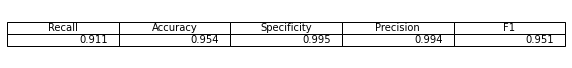

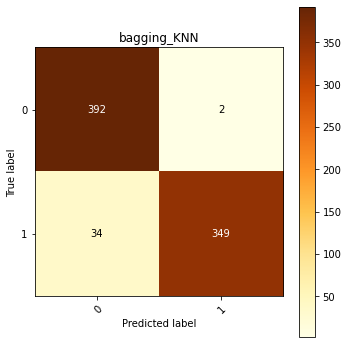

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py", line 407, in _fit
    for i in range(n_jobs)
  File "/opt/conda/lib/

Grid Search completed in 26.344 seconds.
{'base_estimator__C': 100, 'base_estimator__penalty': 'l2', 'max_samples': 0.75}
bagging_LogReg
Cross-validation completed in 1.583 seconds.


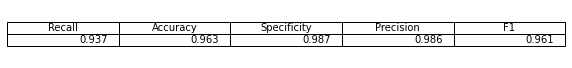

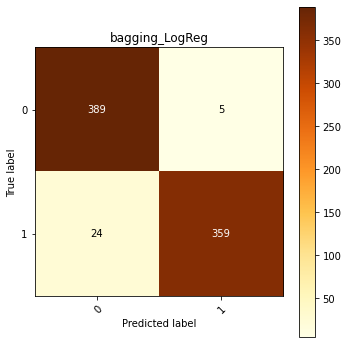



Grid Search completed in 282.518 seconds.
{'base_estimator__C': 10, 'base_estimator__degree': 2, 'base_estimator__gamma': 'auto', 'base_estimator__kernel': 'rbf', 'max_samples': 1.0}
bagging_SVM
Cross-validation completed in 0.537 seconds.


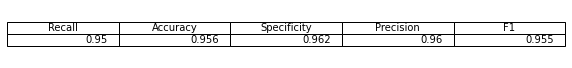

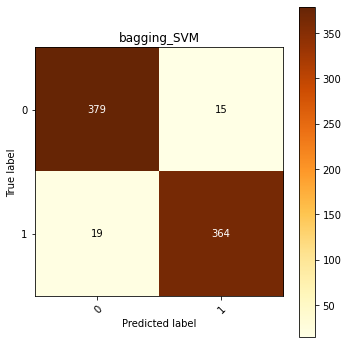

In [53]:
bagging_classifiers = {
    'bagging_KNN': {
        'clf': KNeighborsClassifier(),
        'param_grid': {
            'base_estimator__n_neighbors': [1, 3, 5, 7, 9],
            'base_estimator__weights': ['uniform', 'distance'],
            'base_estimator__p': [1, 2, 3],
            'max_samples' : [0.25, 0.5, 0.75, 1.0]
        },
    },
    'bagging_LogReg': {
        'clf': LogisticRegression(random_state=42, max_iter=500),
        'param_grid': {
            'base_estimator__C': [0.01, 0.1, 1, 10, 100],
            'base_estimator__penalty': ['l1', 'l2'],
            'max_samples' : [0.25, 0.5, 0.75, 1.0]
        }
    },
    'bagging_SVM': {
        'clf': SVC(random_state=42),
        'param_grid': {
            'base_estimator__C': [0.01, 0.1, 1, 10, 100],
            'base_estimator__kernel': ['linear', 'rbf', 'poly'],
            'base_estimator__degree': [2, 3, 4],
            'base_estimator__gamma': ['scale', 'auto'],
            'max_samples' : [0.25, 0.5, 0.75, 1.0]
        }
    }
}

for key, value in bagging_classifiers.items():
    classifier = value

    # start grid search
    start = time.time()
    grid_search = GridSearchCV(BaggingClassifier(classifier['clf'], n_estimators=10, max_features=0.5, random_state=42),
                               classifier['param_grid'],
                               cv=5,
                               scoring='recall')
    grid_search.fit(X_res_train.values, y_res_train.values.ravel())
    end = time.time()
    print("Grid Search completed in", round((round((end - start), 3)), 3), "seconds.")
    print(grid_search.best_params_)
    
    clf = grid_search.best_estimator_
    
    # start cross-val using best parameters for each model
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=5)
    
    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    cf = confusion_matrix(y_res_train.values.ravel(), y_pred)
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Cross-validation completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")
    
scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [54]:
scores_df

,recall,accuracy,specificity,precision,f1
bagging_KNN,0.911,0.954,0.995,0.994,0.951
bagging_LogReg,0.937,0.963,0.987,0.986,0.961
bagging_SVM,0.95,0.956,0.962,0.96,0.955
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951
fine_tuned_DT,0.937,0.936,0.934,0.932,0.935
fine_tuned_KNN,0.927,0.952,0.977,0.975,0.95
fine_tuned_LogReg,0.94,0.965,0.99,0.989,0.964


As we can see, the bagging methods did not perform well as our single fine-tuned classifiers even. The best was the SVM with bagging method, which is close to our fine-tuned SVM classifier (better specificity) but it still has worse recall.

### Random Forest Classifier

Instead of using bagging on Decision Trees, we can use a Random Forest Classifier (and its other variant - ExtraTrees)

Grid Search completed in 157.665 seconds.
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
trees_Random_Forest
Completed in 0.133 seconds.


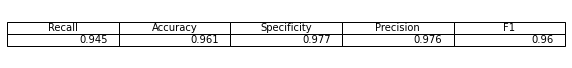

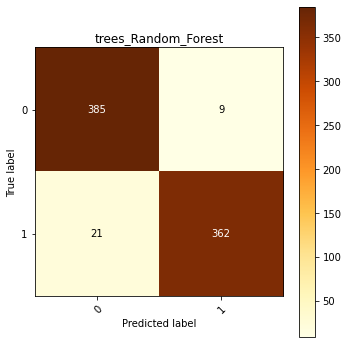



Grid Search completed in 89.793 seconds.
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
trees_ExtraTrees
Completed in 0.574 seconds.


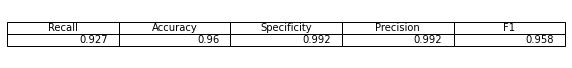

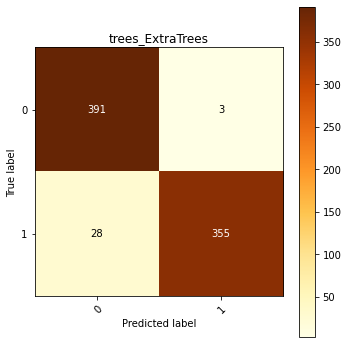

In [55]:
bagging_tree_classifiers = {
    'trees_Random_Forest': {
        'clf': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
    },
    'trees_ExtraTrees': {
        'clf': ExtraTreesClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

for key, value in bagging_tree_classifiers.items():
    classifier = value

    # start grid search
    start = time.time()
    grid_search = GridSearchCV(classifier['clf'], classifier['param_grid'], cv=5, scoring='recall')
    grid_search.fit(X_res_train.values, y_res_train.values.ravel())
    end = time.time()
    print("Grid Search completed in", round((round((end - start), 3)), 3), "seconds.")
    print(grid_search.best_params_)
    
    clf = grid_search.best_estimator_
    
    # start cross-val using best parameters for each model
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=5)
    
    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    cf = confusion_matrix(y_res_train.values.ravel(), y_pred)
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")
    
scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [56]:
scores_df

,recall,accuracy,specificity,precision,f1
bagging_KNN,0.911,0.954,0.995,0.994,0.951
bagging_LogReg,0.937,0.963,0.987,0.986,0.961
bagging_SVM,0.95,0.956,0.962,0.96,0.955
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951
fine_tuned_DT,0.937,0.936,0.934,0.932,0.935
fine_tuned_KNN,0.927,0.952,0.977,0.975,0.95
fine_tuned_LogReg,0.94,0.965,0.99,0.989,0.964


Both the Random Forest and the ExtraTrees classifiers performed better than the fine-tuned Decision Trees and bagging Decision Trees classifiers across the most important metrics (Recall, Accuracy and Specificity). However, the best performing classifier is still the fine-tuned SVM for recall.

### Boosting

Now let's try some boosting classifiers! The two we will assess are ADABoost and GradientBoost (and eXtreme Gradient Boost AKA XGBoost)

Grid Search completed in 38.625 seconds.
{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}
boost_ada
Completed in 3.547 seconds.


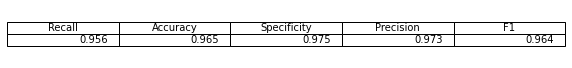

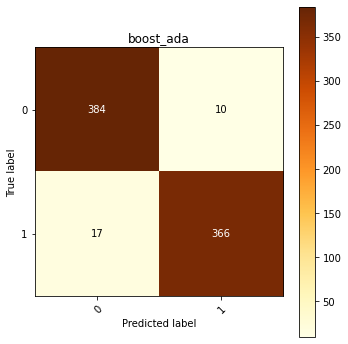



Grid Search completed in 90.313 seconds.
{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}
boost_gradient
Completed in 2.609 seconds.


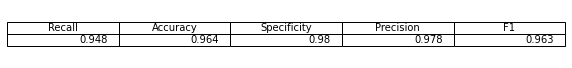

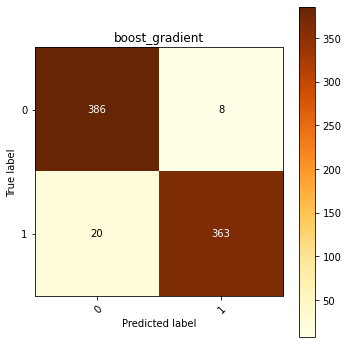



Grid Search completed in 31.669 seconds.
{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}
boost_xg
Completed in 0.26 seconds.


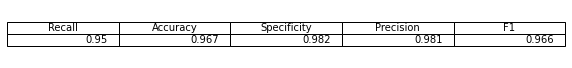

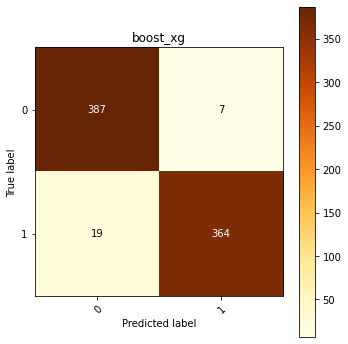

In [57]:
boosting_classifiers = {
    'boost_ada': {
        'clf': AdaBoostClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'algorithm': ["SAMME", "SAMME.R"]
        },
    },
    'boost_gradient': {
        'clf': GradientBoostingClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]
        }
    },
    'boost_xg': {
        'clf': xgb.XGBClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5, 7]
        }
    }
}

for key, value in boosting_classifiers.items():
    classifier = value

    # start grid search
    start = time.time()
    grid_search = GridSearchCV(classifier['clf'], classifier['param_grid'], cv=5, scoring='recall')
    grid_search.fit(X_res_train.values, y_res_train.values.ravel())
    end = time.time()
    print("Grid Search completed in", round((round((end - start), 3)), 3), "seconds.")
    print(grid_search.best_params_)
    
    clf = grid_search.best_estimator_
    
    # start cross-val using best parameters for each model
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=5)
    
    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    cf = confusion_matrix(y_res_train.values.ravel(), y_pred)
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")
    
scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [58]:
scores_df

,recall,accuracy,specificity,precision,f1
bagging_KNN,0.911,0.954,0.995,0.994,0.951
bagging_LogReg,0.937,0.963,0.987,0.986,0.961
bagging_SVM,0.95,0.956,0.962,0.96,0.955
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951
boost_ada,0.956,0.965,0.975,0.973,0.964
boost_gradient,0.948,0.964,0.98,0.978,0.963
boost_xg,0.95,0.967,0.982,0.981,0.966


Fantastic! All the boosting algorithms worked really well! They are rivalling the fine-tuned SVM classifier for recall!

### Voting

The final approach in ensemble learning we will explore is voting, which means we will use different combinations of our strongest classifiers thus far to vote on the predictions of each examples!

ftsvm_booada
Completed in 8.559 seconds.


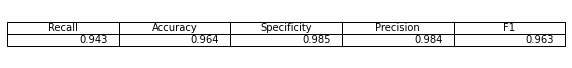

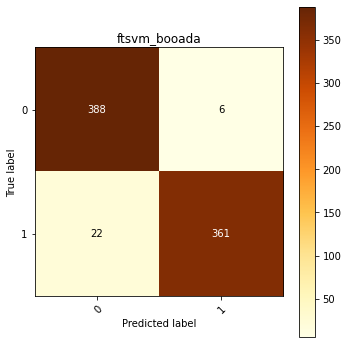



ftsvm_ftknn_booada
Completed in 7.94 seconds.


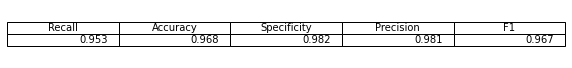

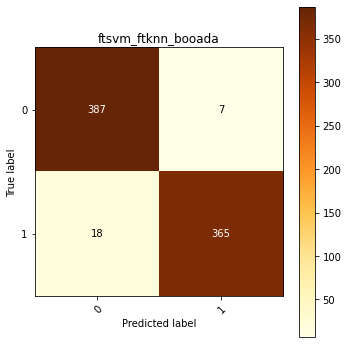



ftsvm_ftknn_baglr
Completed in 3.504 seconds.


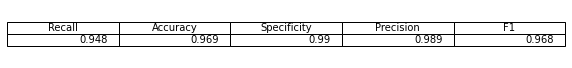

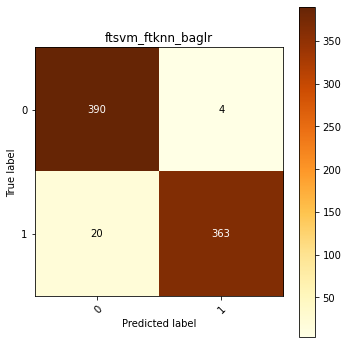



ftsvm_ftknn_booada_baglr
Completed in 11.914 seconds.


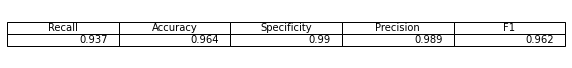

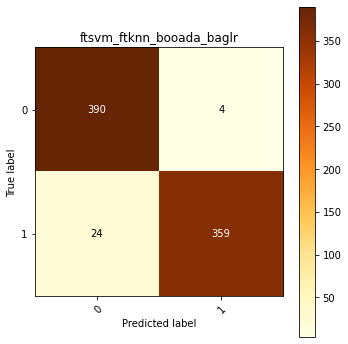

In [59]:
voting_classifiers = {
    'ftsvm_booada': VotingClassifier(estimators=[
        ('ftsvm', classifiers['fine_tuned_SVM']),
        ('booada', classifiers['boost_ada'])
    ]),
    'ftsvm_ftknn_booada': VotingClassifier(estimators=[
        ('ftsvm', classifiers['fine_tuned_SVM']),
        ('ftknn', classifiers['fine_tuned_KNN']),
        ('booada', classifiers['boost_ada'])
    ]),
    'ftsvm_ftknn_baglr': VotingClassifier(estimators=[
        ('ftsvm', classifiers['fine_tuned_SVM']),
        ('ftknn', classifiers['fine_tuned_KNN']),
        ('baglr', classifiers['bagging_LogReg'])
    ]),
    'ftsvm_ftknn_booada_baglr': VotingClassifier(estimators=[
        ('ftsvm', classifiers['fine_tuned_SVM']),
        ('ftknn', classifiers['fine_tuned_KNN']),
        ('booada', classifiers['boost_ada']),
        ('baglr', classifiers['bagging_LogReg'])
    ])
}

for key, value in voting_classifiers.items():
    clf = value

    # start cross-val
    start = time.time()
    
    y_pred = cross_val_predict(clf, X_res_train.values, y_res_train.values.ravel(), cv=10)

    recall = round(recall_score(y_res_train.values.ravel(), y_pred), 3)
    accuracy = round(accuracy_score(y_res_train.values.ravel(), y_pred), 3)
    specificity = round(recall_score(y_res_train.values.ravel(), y_pred, pos_label=0), 3)
    precision = round(precision_score(y_res_train.values.ravel(), y_pred), 3)
    f1 = round(f1_score(y_res_train.values.ravel(), y_pred), 3)
    
    end = time.time()
    
    # save scores
    scores_data[key] = [recall, accuracy, specificity, precision, f1]
    
    # save classifiers
    classifiers[key] = clf

    print(key)
    print("Completed in", round((round((end - start), 3)), 3), "seconds.")
    plot_score_table(recall, accuracy, specificity, precision, f1)
    visualise_confusion_matrix(y_res_train.values.ravel(), y_pred, key)
    print("\n")
    
scores_df = pd.DataFrame.from_dict(scores_data, orient='index', columns=scores_data['scores']).drop('scores').sort_index()

In [60]:
scores_df

,recall,accuracy,specificity,precision,f1
bagging_KNN,0.911,0.954,0.995,0.994,0.951
bagging_LogReg,0.937,0.963,0.987,0.986,0.961
bagging_SVM,0.95,0.956,0.962,0.96,0.955
base_DT,0.927,0.925,0.924,0.922,0.924
base_LogReg,0.927,0.951,0.975,0.973,0.949
base_NB,0.875,0.92,0.964,0.96,0.915
base_SVM,0.911,0.954,0.995,0.994,0.951
boost_ada,0.956,0.965,0.975,0.973,0.964
boost_gradient,0.948,0.964,0.98,0.978,0.963
boost_xg,0.95,0.967,0.982,0.981,0.966


Some great results form voting! I think our best classifier now is the voting classifier which consists of the fine-tuned SVM, the fine-tuned KNN and the ADABoost classifiers! Now we can use this classifier on our test set!

# Testing

In fact, we can use all these models on our test set and then choose the best one since we all have them saved in a classifiers dataframe!

In [61]:
# creating a dictionary to save all the test scores

test_scores = {
    'scores': ['recall', 'accuracy', 'specificity', 'precision', 'f1']
}

In [62]:
# loop through all of our classifiers
for key, value in classifiers.items(): 
    
    # new X and y from our training dataset which only has been through outlier removal
    X_train = df_train.drop('Class', axis=1).values
    y_train = df_train['Class'].values.ravel()

    # creating the objects for our pipeline (scaling, undersampling, classification)
    rbs = RobustScaler()
    rus = RandomUnderSampler(random_state=42)
    tl = TomekLinks()
    clf = value

    # construct pipeline
    pipeline = Pipeline([('rbs', rbs), ('rus', rus), ('tl', tl), ('clf', clf)])
    pipeline.fit(X_train, y_train)
    
    # make predictions on test dataset from the start of the notebook
    y_pred = pipeline.predict(X_test.values)

    # calculate our scores
    recall = round(recall_score(y_test, y_pred), 2)
    accuracy = round(accuracy_score(y_test, y_pred), 2)
    specificity = round(recall_score(y_test, y_pred, pos_label=0), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)
    
    test_scores[key] = [recall, accuracy, specificity, precision, f1]
    
test_scores_df = pd.DataFrame.from_dict(test_scores, orient='index', columns=test_scores['scores']).drop('scores').sort_index()

In [63]:
test_scores_df.sort_values(by='recall', ascending=False)

,recall,accuracy,specificity,precision,f1
fine_tuned_SVM,0.97,0.9,0.9,0.02,0.03
ftsvm_ftknn_booada,0.96,0.95,0.95,0.03,0.06
ftsvm_ftknn_baglr,0.95,0.96,0.96,0.04,0.07
ftsvm_booada,0.94,0.97,0.97,0.05,0.09
boost_ada,0.94,0.95,0.95,0.03,0.06
fine_tuned_KNN,0.94,0.95,0.95,0.03,0.06
bagging_SVM,0.93,0.92,0.92,0.02,0.04
base_LogReg,0.93,0.95,0.95,0.03,0.06
ftsvm_ftknn_booada_baglr,0.93,0.98,0.98,0.06,0.11
boost_xg,0.93,0.96,0.96,0.04,0.07


This is a lot to breakdown! Let's discuss these scores.

## Test Score Discussion

Finally, we have our test scores. I have sorted the test scores by recall since I have stressed time and time again that this is our most important metric. Remember, the main goal is to make sure fraud transactions are detected well. If we manage to classify most fraud transactions, and more at the sacrifice of missclassifying some non-fraud transactions, it may be worth it.

Here, the fine-tuned SVM has the highest recall. It can detect 97% of fraud transactions! However, it missclassified around 10% of non-fraud transactions, which is too many! Therefore, we will not call this our best classifier. Therefore, we can say that our best classifier is actually a choice between the four voting classifiers, (three of which have the three highest recall scores):
* Fine-Tuned SVM + Fine-Tuned KNN + ADABoost (recall sore 96%, specificity 95%)
* Fine-Tuned SVM + Fine-Tuned KNN + Bagging Logistic Regression (recall score 95%, specificity 96%)
* Fine-Tuned SVM + ADABoost (recall score 94%, specificity 97%)
* Fine-Tuned SVM + Fine-Tuned KNN + ADABoost + Bagging Logistic Regression (recall score 93%, specificity 98%)

As you can see, in order, these classifiers sacrifice one percent of recall for one percent of specificity, and vice versa for the opposite order. So which is the best? The truth is, its a personal choice. In my opinion, I would prefer maybe the second choice (Fine-Tuned SVM + Fine-Tuned KNN + Bagging Logistic Regression) since it detects atleast 95% of the fraud transactions, and missclassifies enough of the non-fraud transactions that I could forgive the model (so that it can catch the fraudsters!). So let's finish off by visualising the confusion matrix on the test data for this model.

Also, what's up with the weird precision and f1 scores. Read on to find out!

## Test Visualisation - Confusion Matrix

In [64]:
# our classifier
classifiers['ftsvm_ftknn_baglr']

VotingClassifier(estimators=[('ftsvm',
                              SVC(C=100, degree=2, gamma='auto',
                                  random_state=42)),
                             ('ftknn',
                              KNeighborsClassifier(n_neighbors=1, p=1)),
                             ('baglr',
                              BaggingClassifier(base_estimator=LogisticRegression(C=100,
                                                                                  max_iter=500,
                                                                                  random_state=42),
                                                max_features=0.5,
                                                max_samples=0.75,
                                                random_state=42))])

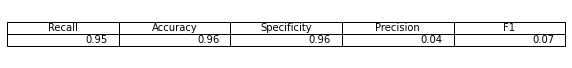

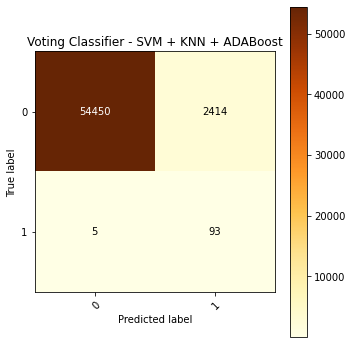

In [65]:
X_train = df_train.drop('Class', axis=1).values
y_train = df_train['Class'].values.ravel()

# creating the objects for our pipeline (scaling, undersampling, classification)
rbs = RobustScaler()
rus = RandomUnderSampler(random_state=42)
tl = TomekLinks()
clf = classifiers['ftsvm_ftknn_baglr'] # Fine-Tuned SVM + Fine-Tuned KNN + Bagging Logistic Regression

# construct pipeline
pipeline = Pipeline([('rbs', rbs), ('rus', rus), ('tl', tl), ('clf', clf)])
pipeline.fit(X_train, y_train)

# make predictions on test dataset from the start of the notebook
y_pred = pipeline.predict(X_test.values)

# calculate our scores
recall = round(recall_score(y_test, y_pred), 2)
accuracy = round(accuracy_score(y_test, y_pred), 2)
specificity = round(recall_score(y_test, y_pred, pos_label=0), 2)
precision = round(precision_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred), 2)

plot_score_table(recall, accuracy, specificity, precision, f1)
visualise_confusion_matrix(y_test, y_pred, 'Voting Classifier - SVM + KNN + ADABoost')

So why the low precision and f1 sore? Well firs remember that precision is True Positives/(True Positives + False Positives). Now, because we are working with an imbalanced dataset, although we are classifying 96% of the non-fraud transactions correctly, the precision score is calculated using the large figure of 2414 and the small figure of 93. It is calculating 93/(93+2414). This is also why we are getting a low f1 score because of the low precision score. This is why in this case, we are better off looking at recall, accuracy and specificity.

# Further Work

There are many other things I wish to cover in a future update such as constructing a classifier using neural networks. I hope to some day come back to this notebook and attempt it but this is my first full project myself so I will leave it for now.

# Citations

### Kaggle Notebooks

Credit Fraud || Dealing with Imbalanced Datasets by JANIO MARTINEZ BACHMANN
https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In depth skewed data classif. (93% recall acc now) by JOPARGA3
https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

Credit Card Fraud Detection Predictive Models by GABRIEL PREDA
https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-predictive-models

### Websites

Credit Card Fraud Detection Project using Machine Learning by ProjectPro
https://www.projectpro.io/article/credit-card-fraud-detection-project-with-source-code-in-python/568#mcetoc_1fsobccm65u